# Импортирование необходимых библиотек

In [1]:
import os
import uuid
import tarfile
import numpy as np
import urllib.request
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import onnx
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Проверка наличия CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    print(f"Driver version: {torch.version.cuda}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available!
Device name: NVIDIA GeForce GTX 1650 Ti
CUDA capability: (7, 5)
Driver version: 12.1
Device count: 1
Current device: 0


# Загрузка и распаковка набора данных CIFAR100

In [3]:
def download_and_extract_cifar100(
    filename="cifar-100-python.tar.gz", 
    url="https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz", 
    extract_dir="cifar-100-python"
    ):
    """
    Функция для скачивания и распаковки архива CIFAR-100.
    
    Args:
        filename (str): Имя архива, который нужно скачать.
        url (str): URL для скачивания архива.
        extract_dir (str): Папка, куда нужно распаковать архив.
    """
    
    # Проверяем наличие файла
    if not os.path.exists(filename):
        # Файла нет, скачиваем
        print(f"Скачивание {filename}...")
        urllib.request.urlretrieve(url, filename)
        print(f"Файл '{filename}' был успешно скачан.")
    else:
        print(f"Файл '{filename}' уже существует.")

    # Проверяем, был ли архив распакован
    if not os.path.exists(extract_dir):
        print(f"Распаковка {filename}...")
        with tarfile.open(filename, "r:gz") as tar:
            tar.extractall()
        print(f"Архив распакован в папку '{extract_dir}'.")
    else:
        print("Архив уже распакован.")
        
download_and_extract_cifar100()

Файл 'cifar-100-python.tar.gz' уже существует.
Архив уже распакован.


## Архитектуры модели

### Класс модели CIFAR100

In [4]:
class CIFAR100Trainer:
    def __init__(self, classes, batch_size=128, lr_rate=1e-4, criterion=nn.CrossEntropyLoss(), experiment_name='default'):
        self.classes = classes
        self.batch_size = batch_size
        self.lr_rate = lr_rate
        self.device = self.check_device()
        self.criterion = criterion
        self.history = {"epoch": [], "loss": []}  # История обучения
        # Загрузка названий классов
        self.class_names = self.load_class_names()
        
        # Уникальная директория для каждого эксперимента
        log_dir = f'logs/{experiment_name}'
        self.writer = SummaryWriter(log_dir=log_dir)

        # Чтение тренировочной выборки (обучающих данных)
        with open('cifar-100-python/train', 'rb') as f:
            data_train = pickle.load(f, encoding='latin1')

        # Чтение тестовой выборки (тестовых данных)
        with open('cifar-100-python/test', 'rb') as f:
            data_test = pickle.load(f, encoding='latin1')

        # Фильтрация данных и создание датасетов
        self.train_dataset = self.prepare_data(data_train, 'train')
        self.test_dataset = self.prepare_data(data_test, 'test')

        # Загрузка данных в батчи
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
        
    def load_class_names(self):
        """Загружает названия классов из мета-файла."""
        with open('cifar-100-python/meta', 'rb') as f:
            meta = pickle.load(f, encoding='latin1')
        return meta['fine_label_names']

    def prepare_data(self, data, part):
        """Фильтрация данных и преобразование в TensorDataset."""
        X = data['data'].reshape(-1, 3, 32, 32)  # Данные в формате NCHW
        X = np.transpose(X, [0, 2, 3, 1]) # NCHW -> NHWC
        y = np.array(data['fine_labels'])

        mask = np.isin(y, self.classes)
        X = X[mask].copy()
        y = y[mask].copy()
        y = np.unique(y, return_inverse=1)[1]

        tensor_x = torch.Tensor(X)
        tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(self.classes)) / 1.
        dataset = TensorDataset(tensor_x, tensor_y)
        return dataset
        
    def train(self, model, epochs=10):
        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=self.lr_rate)
        self.history = {"epoch": [], "loss": []}  # Инициализация истории

        for epoch in range(epochs):
            model.train()  # Установка модели в режим обучения
            running_loss = 0.0

            progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit="batch")
            for batch_idx, (data, target) in enumerate(progress_bar):
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                # Вызов метода forward() модели
                output = model.forward(data) 
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                progress_bar.set_postfix(loss=f"{loss:.6f}")
                
            average_loss = running_loss / len(self.train_loader)
            self.history["epoch"].append(epoch + 1)
            self.history["loss"].append(average_loss)  # Сохранение средней потери
    
            # Логирование потерь в TensorBoard
            self.writer.add_scalar('Loss/train', average_loss, epoch)
            print(f'Epoch: {epoch+1}/{epochs}, Loss: {running_loss/len(self.train_loader):.6f}')
            
        self.writer.close()  # Закрытие SummaryWriter после обучения

    def evaluate(self, model):
        model = model.to(self.device)
        model.eval()  # Установка модели в режим оценки
        
        # Обрабатываем обе выборки: тренировочную и тестовую
        dataloaders = {'train': self.train_loader, 'test': self.test_loader}
        
        for part in ['train', 'test']:
            all_predicted = []
            all_target = []
            with torch.no_grad():
                for data, target in dataloaders[part]:
                    data, target = data.to(self.device), target.to(self.device)
                    output = model(data)
                    
                    # Получаем предсказания
                    _, predicted = torch.max(output.data, 1)
                    
                    # Преобразуем target обратно в одномерный тензор
                    target_indices = torch.argmax(target, dim=1)
                    
                    all_predicted.extend(predicted.cpu().numpy())
                    all_target.extend(target_indices.cpu().numpy())
            
            # Преобразуем списки в массивы NumPy
            all_predicted = np.array(all_predicted)
            all_target = np.array(all_target)
            
            # Выводим наименования классов для выбранных индексов
            selected_class_names = [self.class_names[i] for i in self.classes]
            
            # Выводим отчет о классификации
            print(f"Classification report for {part} dataset:")
            report = classification_report(all_target, all_predicted, target_names=selected_class_names, zero_division=0, digits=4)
            print(report)
            print('-' * 50)
            
        # Вычисляем и логируем точность
        accuracy = np.sum(all_predicted == all_target) / len(all_target)
        self.writer.add_scalar(f'Accuracy/{part}', accuracy, len(self.history["epoch"]) - 1)

    def save_model(self, model, path='models/'):
        # Генерируем уникальный идентификатор
        unique_id = str(uuid.uuid4())  # Генерация уникального ID
        model_name = f"cifar100_{unique_id}.onnx"  # Формируем название модели
        
        # Создаем полный путь для сохранения модели
        filepath = os.path.join(path, model_name)  # Корректное соединение пути и имени файла
        
        # Убедимся, что директория для сохранения существует
        os.makedirs(path, exist_ok=True)  # Создаем директорию, если она не существует

        # Входной тензор для модели (с учетом правильного порядка: (N, H, W, C))
        dummy_input = torch.randn(1, 32, 32, 3, requires_grad=True).to(self.device)  # (N, H, W, C)
    
        # Экспорт модели
        torch.onnx.export(
            model,               # модель
            dummy_input,         # входной тензор
            filepath,            # куда сохранить
            export_params=True,  # сохраняет веса обученных параметров внутри файла модели
            opset_version=9,    # версия ONNX
            do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
            input_names=['input'],    # имя входного слоя
            output_names=['output'],   # имя выходного слоя
            dynamic_axes={'input': {0: 'batch_size'},    # динамичные оси
                          'output': {0: 'batch_size'}}
        )
        
        # Вывод информации о сохраненной модели
        print(f"Model saved as: {model_name}")
        print(f"Model UUID: {unique_id}")

    def check_device(self):
        """Проверяет доступность CUDA и возвращает устройство."""
        if torch.cuda.is_available():
            device = 'cuda'
        else:
            device = 'cpu'
        print(f'Используемое устройство: {device}')
        return device

    def plot_training_history(self):
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
        # Преобразуем список эпох для оси X
        epochs = self.history["epoch"]
    
        # Первый график: Полная история
        axs[0].plot(epochs, self.history["loss"], marker='o', linestyle='-', color='b', markersize=5, label='Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Average Loss')
        axs[0].set_title('Loss Function (Full History)')
        axs[0].grid(True)
        axs[0].legend()
    
        # Второй график: Половина истории
        mid_index = len(epochs) // 2
        axs[1].plot(epochs[mid_index:], self.history["loss"][mid_index:], marker='o', linestyle='-', color='b', markersize=5, label='Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Average Loss')
        axs[1].set_title('Loss Function (Second Half of Training)')
        axs[1].grid(True)
        axs[1].legend()
    
        plt.tight_layout()
        plt.show()

### Нормализация

In [5]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        device = input.device  # Получаем устройство данных
        self.mean = self.mean.to(device)  # Переносим тензоры на это устройство
        self.std = self.std.to(device)
        
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

### Архитектура модели

In [6]:
class CIFAR100Model(nn.Module):
    def __init__(self, hidden_layers=[64, 128, 64], dropout_prob=0.5, num_classes=100):
        super(CIFAR100Model, self).__init__()
        self.norm = Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025])
        
        # Определяем входной размер (например, CIFAR100 имеет изображения размером 32x32x3)
        input_size = 32 * 32 * 3

        # Динамически создаем слои на основе переданного списка hidden_layers
        layers = []
        in_features = input_size
        for i, hidden_size in enumerate(hidden_layers):
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())  # Активационная функция
            layers.append(nn.Dropout(p=dropout_prob))  # Dropout
            in_features = hidden_size

        # Добавляем последний слой для классификации
        layers.append(nn.Linear(in_features, num_classes))

        # Создаем последовательность слоев
        self.seq = nn.Sequential(*layers)

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

## Установки параметров

### По варианту

In [7]:
CLASSES = [94, 21, 51]

## Машинное обучение 

### Эксперимент №1

#### Гиперпараметры

In [8]:
batch_size=2**5
epochs=100
criterion=nn.NLLLoss()
lr_rate = 1e-4
hidden_layers=[2**4, 2**6, 2**4]

#### Инициализация модели

In [9]:
%%time
trainer1 = CIFAR100Trainer(CLASSES, batch_size, lr_rate, criterion, experiment_name='cifar100_001')

Используемое устройство: cuda
CPU times: user 151 ms, sys: 330 ms, total: 481 ms
Wall time: 349 ms


In [10]:
%%time
cifar100_001 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_prob=0.5, 
    num_classes=CLASSES.__len__()
)

CPU times: user 11.1 ms, sys: 1.91 ms, total: 13 ms
Wall time: 1.52 ms


In [11]:
# Инициализация SummaryWriter
writer = SummaryWriter(log_dir=f'logs/cifar100_001')

# Визуализация графа
dummy_input = torch.randn(1, 32, 32, CLASSES.__len__())  # Размер входа для CIFAR100
writer.add_graph(cifar100_001, dummy_input)

# Закройте SummaryWriter
writer.close()

#### Информация о модели

In [12]:
cifar100_001

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=16, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=16, out_features=3, bias=True)
  )
)

#### Обучение

In [13]:
%%time
trainer1.train(cifar100_001, epochs)

Epoch 1/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 150.14batch/s, loss=1.114985]


Epoch: 1/100, Loss: 1.083768


Epoch 2/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 231.80batch/s, loss=0.966868]


Epoch: 2/100, Loss: 1.060620


Epoch 3/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 263.93batch/s, loss=0.955431]


Epoch: 3/100, Loss: 1.036248


Epoch 4/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 262.52batch/s, loss=1.043836]


Epoch: 4/100, Loss: 1.016353


Epoch 5/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 260.52batch/s, loss=0.971837]


Epoch: 5/100, Loss: 0.995702


Epoch 6/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 231.64batch/s, loss=1.195655]


Epoch: 6/100, Loss: 0.971968


Epoch 7/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 246.40batch/s, loss=1.030700]


Epoch: 7/100, Loss: 0.961905


Epoch 8/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 227.48batch/s, loss=0.992895]


Epoch: 8/100, Loss: 0.949484


Epoch 9/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 225.01batch/s, loss=0.998610]


Epoch: 9/100, Loss: 0.910344


Epoch 10/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 235.69batch/s, loss=0.947864]


Epoch: 10/100, Loss: 0.897541


Epoch 11/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 237.23batch/s, loss=0.866170]


Epoch: 11/100, Loss: 0.883853


Epoch 12/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 273.12batch/s, loss=1.043035]


Epoch: 12/100, Loss: 0.865322


Epoch 13/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 292.44batch/s, loss=0.777937]


Epoch: 13/100, Loss: 0.844035


Epoch 14/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 264.58batch/s, loss=1.065697]


Epoch: 14/100, Loss: 0.838440


Epoch 15/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 292.84batch/s, loss=0.891811]


Epoch: 15/100, Loss: 0.812384


Epoch 16/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 331.93batch/s, loss=0.714570]


Epoch: 16/100, Loss: 0.810060


Epoch 17/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 311.40batch/s, loss=0.692281]


Epoch: 17/100, Loss: 0.805066


Epoch 18/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 312.74batch/s, loss=0.713899]


Epoch: 18/100, Loss: 0.777474


Epoch 19/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 295.52batch/s, loss=0.787184]


Epoch: 19/100, Loss: 0.765202


Epoch 20/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 278.32batch/s, loss=0.714696]


Epoch: 20/100, Loss: 0.766427


Epoch 21/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 279.97batch/s, loss=0.775489]


Epoch: 21/100, Loss: 0.745929


Epoch 22/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 299.62batch/s, loss=0.613070]


Epoch: 22/100, Loss: 0.748333


Epoch 23/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 262.49batch/s, loss=0.697834]


Epoch: 23/100, Loss: 0.754139


Epoch 24/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 283.59batch/s, loss=0.668319]


Epoch: 24/100, Loss: 0.719309


Epoch 25/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 300.93batch/s, loss=0.518722]


Epoch: 25/100, Loss: 0.736646


Epoch 26/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 304.30batch/s, loss=0.710157]


Epoch: 26/100, Loss: 0.718433


Epoch 27/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 312.43batch/s, loss=0.583641]


Epoch: 27/100, Loss: 0.723048


Epoch 28/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 282.01batch/s, loss=0.773097]


Epoch: 28/100, Loss: 0.690022


Epoch 29/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 259.60batch/s, loss=0.718866]


Epoch: 29/100, Loss: 0.693908


Epoch 30/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 268.46batch/s, loss=0.592250]


Epoch: 30/100, Loss: 0.689471


Epoch 31/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 287.23batch/s, loss=0.477112]


Epoch: 31/100, Loss: 0.694713


Epoch 32/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 299.55batch/s, loss=0.590714]


Epoch: 32/100, Loss: 0.671081


Epoch 33/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 283.19batch/s, loss=0.865576]


Epoch: 33/100, Loss: 0.671253


Epoch 34/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 291.68batch/s, loss=0.663614]


Epoch: 34/100, Loss: 0.645834


Epoch 35/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 302.13batch/s, loss=0.745264]


Epoch: 35/100, Loss: 0.637871


Epoch 36/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 312.04batch/s, loss=0.813386]


Epoch: 36/100, Loss: 0.637734


Epoch 37/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 316.01batch/s, loss=0.552653]


Epoch: 37/100, Loss: 0.650902


Epoch 38/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 330.06batch/s, loss=0.706858]


Epoch: 38/100, Loss: 0.612354


Epoch 39/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 301.07batch/s, loss=0.913284]


Epoch: 39/100, Loss: 0.634737


Epoch 40/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 294.40batch/s, loss=0.528558]


Epoch: 40/100, Loss: 0.625277


Epoch 41/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 298.31batch/s, loss=0.450120]


Epoch: 41/100, Loss: 0.641180


Epoch 42/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 292.55batch/s, loss=0.616514]


Epoch: 42/100, Loss: 0.624981


Epoch 43/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 278.05batch/s, loss=0.824844]


Epoch: 43/100, Loss: 0.642116


Epoch 44/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 274.58batch/s, loss=0.472413]


Epoch: 44/100, Loss: 0.608273


Epoch 45/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 256.56batch/s, loss=0.628318]


Epoch: 45/100, Loss: 0.605518


Epoch 46/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 301.66batch/s, loss=0.755356]


Epoch: 46/100, Loss: 0.614953


Epoch 47/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 282.51batch/s, loss=0.609809]


Epoch: 47/100, Loss: 0.597452


Epoch 48/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 323.07batch/s, loss=0.497086]


Epoch: 48/100, Loss: 0.594354


Epoch 49/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 299.61batch/s, loss=0.504790]


Epoch: 49/100, Loss: 0.587567


Epoch 50/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 303.55batch/s, loss=0.725351]


Epoch: 50/100, Loss: 0.595075


Epoch 51/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 310.81batch/s, loss=0.784461]


Epoch: 51/100, Loss: 0.580368


Epoch 52/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 322.04batch/s, loss=0.394160]


Epoch: 52/100, Loss: 0.573388


Epoch 53/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 301.97batch/s, loss=0.464280]


Epoch: 53/100, Loss: 0.546444


Epoch 54/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 301.03batch/s, loss=0.611072]


Epoch: 54/100, Loss: 0.564636


Epoch 55/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 317.55batch/s, loss=0.635917]


Epoch: 55/100, Loss: 0.588503


Epoch 56/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 237.77batch/s, loss=0.698234]


Epoch: 56/100, Loss: 0.587020


Epoch 57/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 264.30batch/s, loss=0.580990]


Epoch: 57/100, Loss: 0.554940


Epoch 58/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 243.01batch/s, loss=0.695136]


Epoch: 58/100, Loss: 0.542256


Epoch 59/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 239.82batch/s, loss=0.693185]


Epoch: 59/100, Loss: 0.536977


Epoch 60/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 278.61batch/s, loss=0.400582]


Epoch: 60/100, Loss: 0.548393


Epoch 61/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 237.15batch/s, loss=0.401682]


Epoch: 61/100, Loss: 0.537313


Epoch 62/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 272.79batch/s, loss=0.367128]


Epoch: 62/100, Loss: 0.524842


Epoch 63/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 292.36batch/s, loss=0.440611]


Epoch: 63/100, Loss: 0.521104


Epoch 64/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 320.16batch/s, loss=0.835888]


Epoch: 64/100, Loss: 0.531152


Epoch 65/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 331.22batch/s, loss=0.753526]


Epoch: 65/100, Loss: 0.525000


Epoch 66/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 336.77batch/s, loss=0.605844]


Epoch: 66/100, Loss: 0.519628


Epoch 67/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 341.19batch/s, loss=0.474051]


Epoch: 67/100, Loss: 0.523214


Epoch 68/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 342.25batch/s, loss=0.752977]


Epoch: 68/100, Loss: 0.507124


Epoch 69/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 333.26batch/s, loss=0.536763]


Epoch: 69/100, Loss: 0.514491


Epoch 70/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 330.38batch/s, loss=0.821823]


Epoch: 70/100, Loss: 0.516683


Epoch 71/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 275.12batch/s, loss=0.481064]


Epoch: 71/100, Loss: 0.514461


Epoch 72/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 268.48batch/s, loss=0.374224]


Epoch: 72/100, Loss: 0.493897


Epoch 73/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 311.44batch/s, loss=0.550277]


Epoch: 73/100, Loss: 0.511688


Epoch 74/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 303.34batch/s, loss=0.335415]


Epoch: 74/100, Loss: 0.513357


Epoch 75/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 309.40batch/s, loss=0.471772]


Epoch: 75/100, Loss: 0.494827


Epoch 76/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 339.67batch/s, loss=0.300478]


Epoch: 76/100, Loss: 0.474976


Epoch 77/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 302.46batch/s, loss=0.665653]


Epoch: 77/100, Loss: 0.479680


Epoch 78/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 303.87batch/s, loss=0.574963]


Epoch: 78/100, Loss: 0.482702


Epoch 79/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 312.26batch/s, loss=0.408073]


Epoch: 79/100, Loss: 0.473505


Epoch 80/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 306.78batch/s, loss=0.622293]


Epoch: 80/100, Loss: 0.472446


Epoch 81/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 295.90batch/s, loss=0.402787]


Epoch: 81/100, Loss: 0.501892


Epoch 82/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 293.54batch/s, loss=0.480794]


Epoch: 82/100, Loss: 0.481828


Epoch 83/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 296.13batch/s, loss=0.459485]


Epoch: 83/100, Loss: 0.484222


Epoch 84/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 301.55batch/s, loss=0.395204]


Epoch: 84/100, Loss: 0.466391


Epoch 85/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 314.47batch/s, loss=0.536850]


Epoch: 85/100, Loss: 0.478480


Epoch 86/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 300.53batch/s, loss=0.442633]


Epoch: 86/100, Loss: 0.459651


Epoch 87/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 290.92batch/s, loss=0.361600]


Epoch: 87/100, Loss: 0.462615


Epoch 88/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 307.09batch/s, loss=0.335623]


Epoch: 88/100, Loss: 0.432133


Epoch 89/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 312.30batch/s, loss=0.511498]


Epoch: 89/100, Loss: 0.456622


Epoch 90/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 300.80batch/s, loss=0.316757]


Epoch: 90/100, Loss: 0.449419


Epoch 91/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 299.55batch/s, loss=0.636076]


Epoch: 91/100, Loss: 0.449300


Epoch 92/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 316.12batch/s, loss=0.412832]


Epoch: 92/100, Loss: 0.448191


Epoch 93/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 299.58batch/s, loss=0.530128]


Epoch: 93/100, Loss: 0.467056


Epoch 94/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 308.53batch/s, loss=0.762617]


Epoch: 94/100, Loss: 0.418888


Epoch 95/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 302.72batch/s, loss=0.469778]


Epoch: 95/100, Loss: 0.467230


Epoch 96/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 292.85batch/s, loss=0.397646]


Epoch: 96/100, Loss: 0.411488


Epoch 97/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 309.82batch/s, loss=0.470911]


Epoch: 97/100, Loss: 0.455237


Epoch 98/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 303.22batch/s, loss=0.460695]


Epoch: 98/100, Loss: 0.451286


Epoch 99/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 283.74batch/s, loss=0.566091]


Epoch: 99/100, Loss: 0.412414


Epoch 100/100: 100%|███████████████████████████████| 47/47 [00:00<00:00, 238.70batch/s, loss=0.514596]


Epoch: 100/100, Loss: 0.420464
CPU times: user 16.4 s, sys: 2.3 s, total: 18.7 s
Wall time: 16.8 s


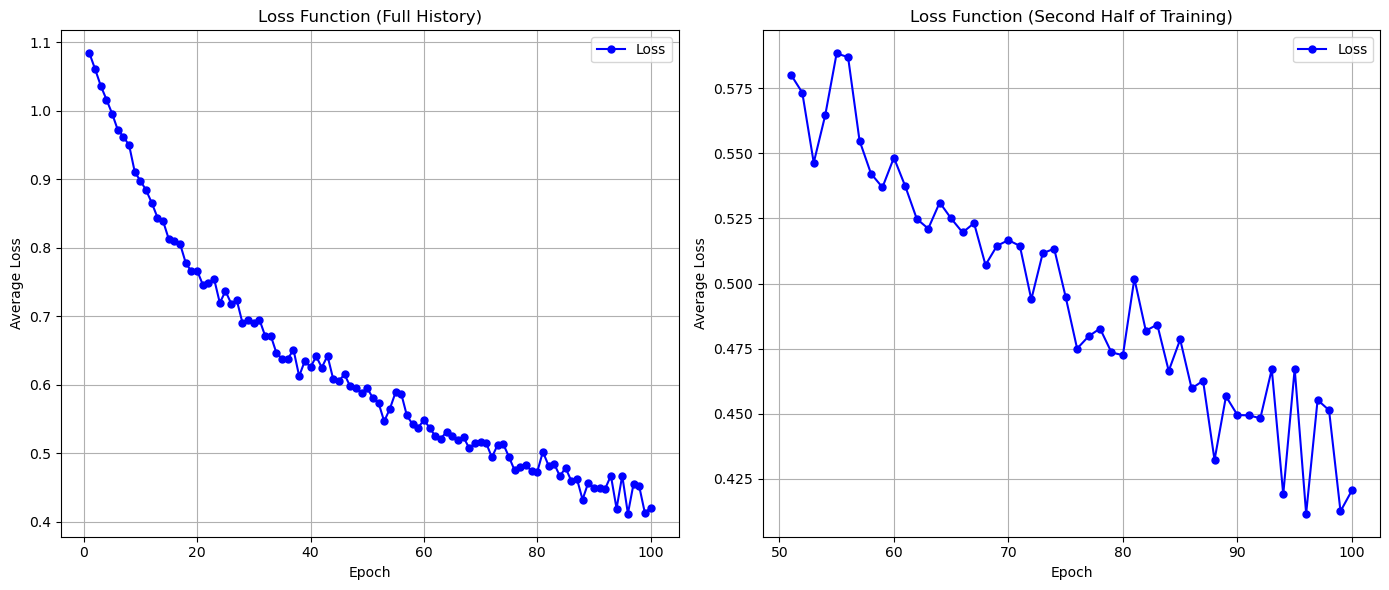

In [14]:
trainer1.plot_training_history()

#### Оценка

In [15]:
trainer1.evaluate(cifar100_001)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9582    0.9620    0.9601       500
  chimpanzee     0.9301    0.9320    0.9311       500
    mushroom     0.9256    0.9200    0.9228       500

    accuracy                         0.9380      1500
   macro avg     0.9380    0.9380    0.9380      1500
weighted avg     0.9380    0.9380    0.9380      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.8317    0.8400    0.8358       100
  chimpanzee     0.8242    0.7500    0.7853       100
    mushroom     0.7130    0.7700    0.7404       100

    accuracy                         0.7867       300
   macro avg     0.7896    0.7867    0.7872       300
weighted avg     0.7896    0.7867    0.7872       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [16]:
trainer1.save_model(cifar100_001)

Model saved as: cifar100_01c774de-ec2a-4b1a-a8b7-228c667a92b4.onnx
Model UUID: 01c774de-ec2a-4b1a-a8b7-228c667a92b4


### Эксперимент №2

#### Гиперпараметры

In [17]:
batch_size=2**5
epochs=100
criterion=nn.NLLLoss()
lr_rate = 1e-4
hidden_layers=[2**6, 2**10, 2**12, 2**10, 2**6]

#### Инициализация модели

In [18]:
%%time
trainer2 = CIFAR100Trainer(CLASSES, batch_size, lr_rate, criterion, experiment_name='cifar100_002')

Используемое устройство: cuda
CPU times: user 177 ms, sys: 282 ms, total: 459 ms
Wall time: 327 ms


In [19]:
%%time
cifar100_002 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_prob=0.5, 
    num_classes=CLASSES.__len__()
)

CPU times: user 357 ms, sys: 35.4 ms, total: 393 ms
Wall time: 48.9 ms


In [20]:
# Инициализация SummaryWriter
writer = SummaryWriter(log_dir=f'logs/cifar100_002')

# Визуализация графа
dummy_input = torch.randn(1, 32, 32, CLASSES.__len__())  # Размер входа для CIFAR100
writer.add_graph(cifar100_002, dummy_input)

# Закройте SummaryWriter
writer.close()

#### Информация о модели

In [21]:
cifar100_002

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=1024, out_features=4096, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=4096, out_features=1024, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=1024, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=64, out_features=3, bias=True)
  )
)

#### Обучение

In [22]:
%%time
trainer2.train(cifar100_002, epochs)

Epoch 1/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 143.79batch/s, loss=0.993468]


Epoch: 1/100, Loss: 1.057896


Epoch 2/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 137.86batch/s, loss=0.833593]


Epoch: 2/100, Loss: 0.832513


Epoch 3/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 138.79batch/s, loss=0.564399]


Epoch: 3/100, Loss: 0.699116


Epoch 4/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 141.84batch/s, loss=0.618391]


Epoch: 4/100, Loss: 0.673759


Epoch 5/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 141.28batch/s, loss=0.541240]


Epoch: 5/100, Loss: 0.587537


Epoch 6/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 141.47batch/s, loss=0.570844]


Epoch: 6/100, Loss: 0.565632


Epoch 7/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 142.20batch/s, loss=0.840362]


Epoch: 7/100, Loss: 0.515438


Epoch 8/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 140.55batch/s, loss=0.435042]


Epoch: 8/100, Loss: 0.499128


Epoch 9/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 143.18batch/s, loss=0.294593]


Epoch: 9/100, Loss: 0.474763


Epoch 10/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 147.30batch/s, loss=0.389467]


Epoch: 10/100, Loss: 0.443040


Epoch 11/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 140.20batch/s, loss=0.301345]


Epoch: 11/100, Loss: 0.457125


Epoch 12/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 137.90batch/s, loss=0.379656]


Epoch: 12/100, Loss: 0.411553


Epoch 13/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 134.53batch/s, loss=0.370147]


Epoch: 13/100, Loss: 0.409959


Epoch 14/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 134.26batch/s, loss=0.601999]


Epoch: 14/100, Loss: 0.407976


Epoch 15/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 134.61batch/s, loss=0.561232]


Epoch: 15/100, Loss: 0.363205


Epoch 16/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 133.87batch/s, loss=0.439988]


Epoch: 16/100, Loss: 0.349922


Epoch 17/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 134.39batch/s, loss=0.246785]


Epoch: 17/100, Loss: 0.351758


Epoch 18/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 133.62batch/s, loss=0.550193]


Epoch: 18/100, Loss: 0.366639


Epoch 19/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 133.20batch/s, loss=0.104225]


Epoch: 19/100, Loss: 0.312371


Epoch 20/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.99batch/s, loss=0.393897]


Epoch: 20/100, Loss: 0.302230


Epoch 21/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.94batch/s, loss=0.211979]


Epoch: 21/100, Loss: 0.289688


Epoch 22/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 130.96batch/s, loss=0.528036]


Epoch: 22/100, Loss: 0.283895


Epoch 23/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 129.32batch/s, loss=0.180267]


Epoch: 23/100, Loss: 0.280741


Epoch 24/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.48batch/s, loss=0.167801]


Epoch: 24/100, Loss: 0.259545


Epoch 25/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.88batch/s, loss=0.468873]


Epoch: 25/100, Loss: 0.269688


Epoch 26/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 130.32batch/s, loss=0.366730]


Epoch: 26/100, Loss: 0.272210


Epoch 27/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.12batch/s, loss=0.442810]


Epoch: 27/100, Loss: 0.222503


Epoch 28/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 126.08batch/s, loss=0.480248]


Epoch: 28/100, Loss: 0.226738


Epoch 29/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 126.03batch/s, loss=0.275142]


Epoch: 29/100, Loss: 0.265920


Epoch 30/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 119.82batch/s, loss=0.494163]


Epoch: 30/100, Loss: 0.226677


Epoch 31/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.58batch/s, loss=0.044874]


Epoch: 31/100, Loss: 0.201641


Epoch 32/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 125.41batch/s, loss=0.133821]


Epoch: 32/100, Loss: 0.216070


Epoch 33/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.89batch/s, loss=0.128005]


Epoch: 33/100, Loss: 0.213189


Epoch 34/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.94batch/s, loss=0.168497]


Epoch: 34/100, Loss: 0.213575


Epoch 35/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.91batch/s, loss=0.086989]


Epoch: 35/100, Loss: 0.200157


Epoch 36/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 130.80batch/s, loss=0.349063]


Epoch: 36/100, Loss: 0.223622


Epoch 37/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 132.14batch/s, loss=0.232263]


Epoch: 37/100, Loss: 0.222028


Epoch 38/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 127.36batch/s, loss=0.267596]


Epoch: 38/100, Loss: 0.183285


Epoch 39/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.19batch/s, loss=0.075817]


Epoch: 39/100, Loss: 0.221628


Epoch 40/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 125.33batch/s, loss=0.034276]


Epoch: 40/100, Loss: 0.184054


Epoch 41/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.36batch/s, loss=0.114584]


Epoch: 41/100, Loss: 0.172045


Epoch 42/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 127.10batch/s, loss=0.085686]


Epoch: 42/100, Loss: 0.172722


Epoch 43/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 125.78batch/s, loss=0.378293]


Epoch: 43/100, Loss: 0.179146


Epoch 44/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.29batch/s, loss=0.562561]


Epoch: 44/100, Loss: 0.174113


Epoch 45/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 120.96batch/s, loss=0.119441]


Epoch: 45/100, Loss: 0.183376


Epoch 46/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 124.49batch/s, loss=0.108872]


Epoch: 46/100, Loss: 0.192670


Epoch 47/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 125.31batch/s, loss=0.139432]


Epoch: 47/100, Loss: 0.164539


Epoch 48/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 122.13batch/s, loss=0.053195]


Epoch: 48/100, Loss: 0.174278


Epoch 49/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 124.57batch/s, loss=0.203162]


Epoch: 49/100, Loss: 0.170272


Epoch 50/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.16batch/s, loss=0.108974]


Epoch: 50/100, Loss: 0.154307


Epoch 51/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.39batch/s, loss=0.074694]


Epoch: 51/100, Loss: 0.146007


Epoch 52/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 122.51batch/s, loss=0.093090]


Epoch: 52/100, Loss: 0.146497


Epoch 53/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 121.94batch/s, loss=0.270981]


Epoch: 53/100, Loss: 0.152550


Epoch 54/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.83batch/s, loss=0.733957]


Epoch: 54/100, Loss: 0.159999


Epoch 55/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 121.76batch/s, loss=0.124165]


Epoch: 55/100, Loss: 0.129399


Epoch 56/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 122.19batch/s, loss=0.251962]


Epoch: 56/100, Loss: 0.159843


Epoch 57/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 121.05batch/s, loss=0.053656]


Epoch: 57/100, Loss: 0.141183


Epoch 58/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 122.14batch/s, loss=0.125572]


Epoch: 58/100, Loss: 0.116809


Epoch 59/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.17batch/s, loss=0.139162]


Epoch: 59/100, Loss: 0.148140


Epoch 60/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.11batch/s, loss=0.319715]


Epoch: 60/100, Loss: 0.142919


Epoch 61/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 122.63batch/s, loss=0.059250]


Epoch: 61/100, Loss: 0.149287


Epoch 62/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.28batch/s, loss=0.054395]


Epoch: 62/100, Loss: 0.120696


Epoch 63/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 122.68batch/s, loss=0.227479]


Epoch: 63/100, Loss: 0.142103


Epoch 64/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.59batch/s, loss=0.154211]


Epoch: 64/100, Loss: 0.154290


Epoch 65/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.49batch/s, loss=0.119313]


Epoch: 65/100, Loss: 0.115451


Epoch 66/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 130.25batch/s, loss=0.166369]


Epoch: 66/100, Loss: 0.118095


Epoch 67/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 136.76batch/s, loss=0.394689]


Epoch: 67/100, Loss: 0.130833


Epoch 68/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 130.41batch/s, loss=0.066271]


Epoch: 68/100, Loss: 0.110636


Epoch 69/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.73batch/s, loss=0.355293]


Epoch: 69/100, Loss: 0.124706


Epoch 70/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 133.96batch/s, loss=0.048606]


Epoch: 70/100, Loss: 0.133704


Epoch 71/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 134.57batch/s, loss=0.066880]


Epoch: 71/100, Loss: 0.099984


Epoch 72/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 125.89batch/s, loss=0.158283]


Epoch: 72/100, Loss: 0.090616


Epoch 73/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 124.57batch/s, loss=0.119505]


Epoch: 73/100, Loss: 0.091470


Epoch 74/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 134.07batch/s, loss=0.093793]


Epoch: 74/100, Loss: 0.119189


Epoch 75/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.52batch/s, loss=0.061555]


Epoch: 75/100, Loss: 0.120048


Epoch 76/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.08batch/s, loss=0.059889]


Epoch: 76/100, Loss: 0.099477


Epoch 77/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 121.58batch/s, loss=0.125246]


Epoch: 77/100, Loss: 0.103883


Epoch 78/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 122.18batch/s, loss=0.048507]


Epoch: 78/100, Loss: 0.113451


Epoch 79/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 124.63batch/s, loss=0.094839]


Epoch: 79/100, Loss: 0.095602


Epoch 80/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 125.81batch/s, loss=0.292311]


Epoch: 80/100, Loss: 0.114557


Epoch 81/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 121.81batch/s, loss=0.221250]


Epoch: 81/100, Loss: 0.087996


Epoch 82/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 124.14batch/s, loss=0.077093]


Epoch: 82/100, Loss: 0.116605


Epoch 83/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 122.56batch/s, loss=0.049445]


Epoch: 83/100, Loss: 0.094908


Epoch 84/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.71batch/s, loss=0.271365]


Epoch: 84/100, Loss: 0.120770


Epoch 85/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.96batch/s, loss=0.112685]


Epoch: 85/100, Loss: 0.078618


Epoch 86/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 125.14batch/s, loss=0.256836]


Epoch: 86/100, Loss: 0.106330


Epoch 87/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 122.16batch/s, loss=0.282369]


Epoch: 87/100, Loss: 0.100037


Epoch 88/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 120.64batch/s, loss=0.051691]


Epoch: 88/100, Loss: 0.126007


Epoch 89/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 130.33batch/s, loss=0.031405]


Epoch: 89/100, Loss: 0.116860


Epoch 90/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 130.38batch/s, loss=0.037316]


Epoch: 90/100, Loss: 0.096070


Epoch 91/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 132.60batch/s, loss=0.270664]


Epoch: 91/100, Loss: 0.082202


Epoch 92/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 127.50batch/s, loss=0.009711]


Epoch: 92/100, Loss: 0.075262


Epoch 93/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 121.89batch/s, loss=1.288701]


Epoch: 93/100, Loss: 0.124577


Epoch 94/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 134.59batch/s, loss=0.113682]


Epoch: 94/100, Loss: 0.122466


Epoch 95/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 132.80batch/s, loss=0.107521]


Epoch: 95/100, Loss: 0.110153


Epoch 96/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 133.98batch/s, loss=0.017975]


Epoch: 96/100, Loss: 0.081251


Epoch 97/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 127.58batch/s, loss=0.093932]


Epoch: 97/100, Loss: 0.084814


Epoch 98/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.48batch/s, loss=0.156547]


Epoch: 98/100, Loss: 0.137743


Epoch 99/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.93batch/s, loss=0.040739]


Epoch: 99/100, Loss: 0.110746


Epoch 100/100: 100%|███████████████████████████████| 47/47 [00:00<00:00, 134.04batch/s, loss=0.419891]

Epoch: 100/100, Loss: 0.093230
CPU times: user 22.6 s, sys: 16.2 s, total: 38.8 s
Wall time: 36.8 s


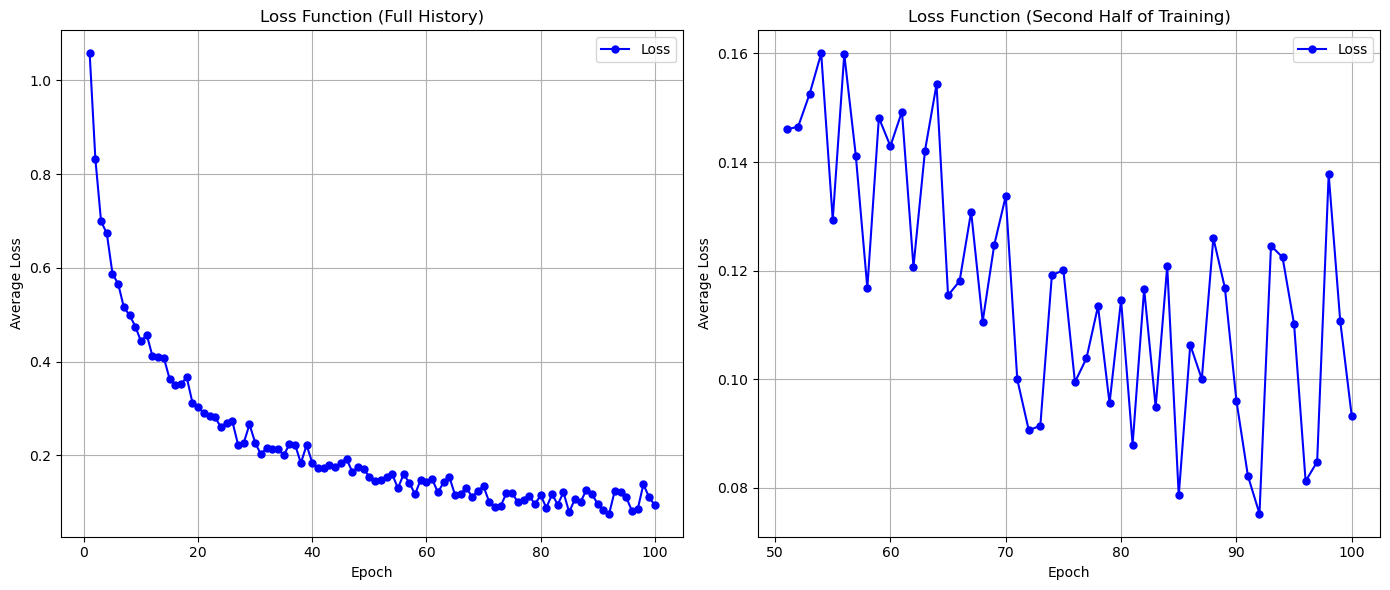

In [23]:
trainer2.plot_training_history()

#### Оценка

In [24]:
trainer2.evaluate(cifar100_002)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9901    0.9980    0.9940       500
  chimpanzee     0.9728    1.0000    0.9862       500
    mushroom     1.0000    0.9640    0.9817       500

    accuracy                         0.9873      1500
   macro avg     0.9876    0.9873    0.9873      1500
weighted avg     0.9876    0.9873    0.9873      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.8519    0.9200    0.8846       100
  chimpanzee     0.8627    0.8800    0.8713       100
    mushroom     0.8889    0.8000    0.8421       100

    accuracy                         0.8667       300
   macro avg     0.8678    0.8667    0.8660       300
weighted avg     0.8678    0.8667    0.8660       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [25]:
trainer2.save_model(cifar100_002)

Model saved as: cifar100_225624a2-567f-4290-8399-3bc778b60d1c.onnx
Model UUID: 225624a2-567f-4290-8399-3bc778b60d1c


### Эксперимент №3

#### Гиперпараметры

In [26]:
batch_size=2**5
epochs=100
criterion=nn.CrossEntropyLoss()
lr_rate = 1e-4
hidden_layers=[2**6, 2**10, 2**12, 2**10, 2**6]

#### Инициализация модели

In [27]:
%%time
trainer3 = CIFAR100Trainer(CLASSES, batch_size, lr_rate, criterion, experiment_name='cifar100_003')

Используемое устройство: cuda
CPU times: user 157 ms, sys: 261 ms, total: 418 ms
Wall time: 306 ms


In [28]:
%%time
cifar100_003 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_prob=0.5, 
    num_classes=CLASSES.__len__()
)

CPU times: user 263 ms, sys: 18.3 ms, total: 281 ms
Wall time: 34.9 ms


In [29]:
# Инициализация SummaryWriter
writer = SummaryWriter(log_dir=f'logs/cifar100_003')

# Визуализация графа
dummy_input = torch.randn(1, 32, 32, CLASSES.__len__())  # Размер входа для CIFAR100
writer.add_graph(cifar100_003, dummy_input)

# Закройте SummaryWriter
writer.close()

#### Информация о модели

In [30]:
cifar100_003

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=1024, out_features=4096, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=4096, out_features=1024, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=1024, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=64, out_features=3, bias=True)
  )
)

#### Обучение

In [31]:
%%time
trainer3.train(cifar100_003, epochs)

Epoch 1/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 139.82batch/s, loss=1.017954]


Epoch: 1/100, Loss: 1.073276


Epoch 2/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 142.52batch/s, loss=0.771469]


Epoch: 2/100, Loss: 0.854622


Epoch 3/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 140.53batch/s, loss=0.735440]


Epoch: 3/100, Loss: 0.693044


Epoch 4/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 131.42batch/s, loss=0.548730]


Epoch: 4/100, Loss: 0.631814


Epoch 5/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 132.17batch/s, loss=0.606863]


Epoch: 5/100, Loss: 0.598347


Epoch 6/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 135.46batch/s, loss=0.318790]


Epoch: 6/100, Loss: 0.556197


Epoch 7/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 133.30batch/s, loss=0.481595]


Epoch: 7/100, Loss: 0.540505


Epoch 8/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 137.30batch/s, loss=0.450166]


Epoch: 8/100, Loss: 0.512895


Epoch 9/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 138.91batch/s, loss=0.528866]


Epoch: 9/100, Loss: 0.496723


Epoch 10/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 137.68batch/s, loss=0.301348]


Epoch: 10/100, Loss: 0.463051


Epoch 11/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 138.46batch/s, loss=0.445449]


Epoch: 11/100, Loss: 0.452189


Epoch 12/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 135.49batch/s, loss=0.271740]


Epoch: 12/100, Loss: 0.436639


Epoch 13/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.37batch/s, loss=0.446158]


Epoch: 13/100, Loss: 0.414032


Epoch 14/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.61batch/s, loss=0.525443]


Epoch: 14/100, Loss: 0.373085


Epoch 15/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 129.05batch/s, loss=0.203698]


Epoch: 15/100, Loss: 0.384327


Epoch 16/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 127.50batch/s, loss=0.802078]


Epoch: 16/100, Loss: 0.349380


Epoch 17/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.18batch/s, loss=0.279047]


Epoch: 17/100, Loss: 0.333674


Epoch 18/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 127.85batch/s, loss=0.246161]


Epoch: 18/100, Loss: 0.345712


Epoch 19/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.86batch/s, loss=0.148585]


Epoch: 19/100, Loss: 0.310402


Epoch 20/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.75batch/s, loss=0.906215]


Epoch: 20/100, Loss: 0.305954


Epoch 21/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 134.12batch/s, loss=0.117191]


Epoch: 21/100, Loss: 0.306386


Epoch 22/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 134.67batch/s, loss=0.341337]


Epoch: 22/100, Loss: 0.295063


Epoch 23/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 130.18batch/s, loss=0.408258]


Epoch: 23/100, Loss: 0.263636


Epoch 24/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 123.22batch/s, loss=0.078823]


Epoch: 24/100, Loss: 0.276558


Epoch 25/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 121.65batch/s, loss=0.226918]


Epoch: 25/100, Loss: 0.291771


Epoch 26/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 125.51batch/s, loss=0.140368]


Epoch: 26/100, Loss: 0.238639


Epoch 27/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.18batch/s, loss=0.163325]


Epoch: 27/100, Loss: 0.287226


Epoch 28/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 126.38batch/s, loss=0.286267]


Epoch: 28/100, Loss: 0.244567


Epoch 29/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 125.42batch/s, loss=0.427942]


Epoch: 29/100, Loss: 0.252488


Epoch 30/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.00batch/s, loss=0.133053]


Epoch: 30/100, Loss: 0.239940


Epoch 31/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.30batch/s, loss=0.343412]


Epoch: 31/100, Loss: 0.253260


Epoch 32/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.11batch/s, loss=0.431118]


Epoch: 32/100, Loss: 0.259928


Epoch 33/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.38batch/s, loss=0.128559]


Epoch: 33/100, Loss: 0.214283


Epoch 34/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 129.34batch/s, loss=0.174000]


Epoch: 34/100, Loss: 0.214746


Epoch 35/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.38batch/s, loss=0.191578]


Epoch: 35/100, Loss: 0.216653


Epoch 36/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.20batch/s, loss=0.136571]


Epoch: 36/100, Loss: 0.219884


Epoch 37/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 133.02batch/s, loss=0.125303]


Epoch: 37/100, Loss: 0.214545


Epoch 38/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.12batch/s, loss=0.242021]


Epoch: 38/100, Loss: 0.175054


Epoch 39/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 132.33batch/s, loss=0.201406]


Epoch: 39/100, Loss: 0.191096


Epoch 40/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.23batch/s, loss=0.625742]


Epoch: 40/100, Loss: 0.203459


Epoch 41/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.36batch/s, loss=0.171502]


Epoch: 41/100, Loss: 0.210167


Epoch 42/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 130.85batch/s, loss=0.084483]


Epoch: 42/100, Loss: 0.188593


Epoch 43/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.13batch/s, loss=0.116168]


Epoch: 43/100, Loss: 0.195935


Epoch 44/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 134.94batch/s, loss=0.191367]


Epoch: 44/100, Loss: 0.170295


Epoch 45/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 135.68batch/s, loss=0.311306]


Epoch: 45/100, Loss: 0.182281


Epoch 46/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.87batch/s, loss=0.060042]


Epoch: 46/100, Loss: 0.166643


Epoch 47/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 130.98batch/s, loss=0.307455]


Epoch: 47/100, Loss: 0.141878


Epoch 48/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.17batch/s, loss=0.156247]


Epoch: 48/100, Loss: 0.152329


Epoch 49/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 130.89batch/s, loss=0.225504]


Epoch: 49/100, Loss: 0.151274


Epoch 50/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.05batch/s, loss=0.158833]


Epoch: 50/100, Loss: 0.189957


Epoch 51/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.67batch/s, loss=0.283202]


Epoch: 51/100, Loss: 0.149715


Epoch 52/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 132.30batch/s, loss=0.267348]


Epoch: 52/100, Loss: 0.165284


Epoch 53/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.20batch/s, loss=0.172521]


Epoch: 53/100, Loss: 0.150971


Epoch 54/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 129.95batch/s, loss=0.028579]


Epoch: 54/100, Loss: 0.142103


Epoch 55/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 138.97batch/s, loss=0.351173]


Epoch: 55/100, Loss: 0.161190


Epoch 56/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 139.86batch/s, loss=0.161503]


Epoch: 56/100, Loss: 0.138282


Epoch 57/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 133.76batch/s, loss=0.152080]


Epoch: 57/100, Loss: 0.179106


Epoch 58/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 126.67batch/s, loss=0.058848]


Epoch: 58/100, Loss: 0.166058


Epoch 59/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.65batch/s, loss=0.066605]


Epoch: 59/100, Loss: 0.134785


Epoch 60/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 125.52batch/s, loss=0.046775]


Epoch: 60/100, Loss: 0.136615


Epoch 61/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.64batch/s, loss=0.195284]


Epoch: 61/100, Loss: 0.148382


Epoch 62/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.76batch/s, loss=0.077231]


Epoch: 62/100, Loss: 0.135073


Epoch 63/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 132.79batch/s, loss=0.085166]


Epoch: 63/100, Loss: 0.105414


Epoch 64/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.74batch/s, loss=0.184136]


Epoch: 64/100, Loss: 0.127177


Epoch 65/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 129.61batch/s, loss=0.037332]


Epoch: 65/100, Loss: 0.132854


Epoch 66/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.25batch/s, loss=0.023963]


Epoch: 66/100, Loss: 0.116137


Epoch 67/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 129.34batch/s, loss=0.141644]


Epoch: 67/100, Loss: 0.125137


Epoch 68/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 126.82batch/s, loss=0.276697]


Epoch: 68/100, Loss: 0.147292


Epoch 69/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 125.85batch/s, loss=0.055016]


Epoch: 69/100, Loss: 0.113864


Epoch 70/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.65batch/s, loss=0.126319]


Epoch: 70/100, Loss: 0.167410


Epoch 71/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 127.03batch/s, loss=0.027012]


Epoch: 71/100, Loss: 0.123600


Epoch 72/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.86batch/s, loss=0.140994]


Epoch: 72/100, Loss: 0.119336


Epoch 73/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.01batch/s, loss=0.023210]


Epoch: 73/100, Loss: 0.116020


Epoch 74/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 132.15batch/s, loss=0.012563]


Epoch: 74/100, Loss: 0.079785


Epoch 75/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 136.69batch/s, loss=0.146967]


Epoch: 75/100, Loss: 0.104167


Epoch 76/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 140.11batch/s, loss=0.094493]


Epoch: 76/100, Loss: 0.104358


Epoch 77/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 129.82batch/s, loss=0.036743]


Epoch: 77/100, Loss: 0.115320


Epoch 78/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 126.91batch/s, loss=0.214207]


Epoch: 78/100, Loss: 0.114713


Epoch 79/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.08batch/s, loss=0.027263]


Epoch: 79/100, Loss: 0.142814


Epoch 80/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 129.86batch/s, loss=0.025599]


Epoch: 80/100, Loss: 0.125442


Epoch 81/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.31batch/s, loss=0.065439]


Epoch: 81/100, Loss: 0.120322


Epoch 82/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.33batch/s, loss=0.161469]


Epoch: 82/100, Loss: 0.113751


Epoch 83/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 136.36batch/s, loss=0.348717]


Epoch: 83/100, Loss: 0.115296


Epoch 84/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 136.95batch/s, loss=0.041300]


Epoch: 84/100, Loss: 0.083647


Epoch 85/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 137.39batch/s, loss=0.014818]


Epoch: 85/100, Loss: 0.139051


Epoch 86/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 137.94batch/s, loss=0.031467]


Epoch: 86/100, Loss: 0.095490


Epoch 87/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 138.21batch/s, loss=0.011896]


Epoch: 87/100, Loss: 0.121271


Epoch 88/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.94batch/s, loss=0.058575]


Epoch: 88/100, Loss: 0.093387


Epoch 89/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 137.98batch/s, loss=0.174476]


Epoch: 89/100, Loss: 0.109586


Epoch 90/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 139.23batch/s, loss=0.083058]


Epoch: 90/100, Loss: 0.087372


Epoch 91/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.10batch/s, loss=0.084595]


Epoch: 91/100, Loss: 0.091664


Epoch 92/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 137.53batch/s, loss=0.138499]


Epoch: 92/100, Loss: 0.092189


Epoch 93/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 136.86batch/s, loss=0.046719]


Epoch: 93/100, Loss: 0.092757


Epoch 94/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 128.19batch/s, loss=0.044763]


Epoch: 94/100, Loss: 0.084654


Epoch 95/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 130.98batch/s, loss=0.387862]


Epoch: 95/100, Loss: 0.101462


Epoch 96/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.36batch/s, loss=0.102734]


Epoch: 96/100, Loss: 0.106873


Epoch 97/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.58batch/s, loss=0.038864]


Epoch: 97/100, Loss: 0.106465


Epoch 98/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.94batch/s, loss=0.035376]


Epoch: 98/100, Loss: 0.104454


Epoch 99/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 131.39batch/s, loss=0.050548]


Epoch: 99/100, Loss: 0.111599


Epoch 100/100: 100%|███████████████████████████████| 47/47 [00:00<00:00, 131.59batch/s, loss=0.220034]

Epoch: 100/100, Loss: 0.109854
CPU times: user 21.3 s, sys: 16.8 s, total: 38.1 s
Wall time: 36 s


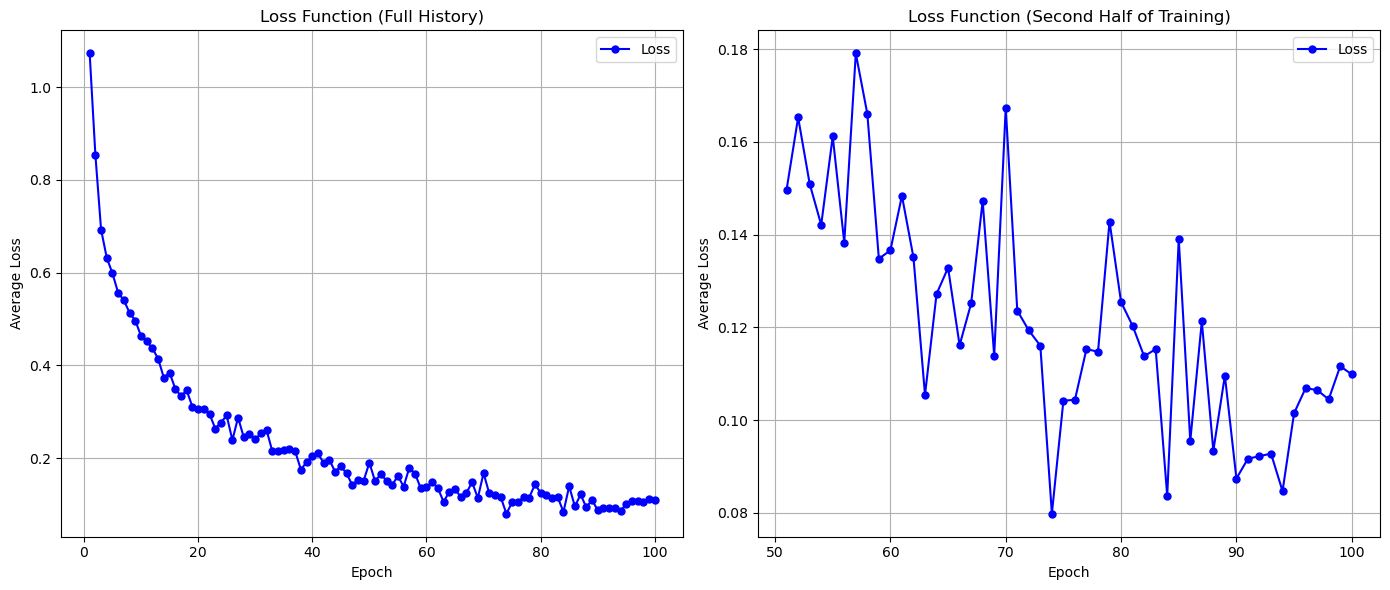

In [32]:
trainer3.plot_training_history()

#### Оценка

In [33]:
trainer3.evaluate(cifar100_003)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     1.0000    1.0000    1.0000       500
  chimpanzee     1.0000    1.0000    1.0000       500
    mushroom     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.8679    0.9200    0.8932       100
  chimpanzee     0.8778    0.7900    0.8316       100
    mushroom     0.8173    0.8500    0.8333       100

    accuracy                         0.8533       300
   macro avg     0.8543    0.8533    0.8527       300
weighted avg     0.8543    0.8533    0.8527       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [34]:
trainer3.save_model(cifar100_003)

Model saved as: cifar100_cd9f3a2a-eb49-4d50-b31f-4a4d30d1b382.onnx
Model UUID: cd9f3a2a-eb49-4d50-b31f-4a4d30d1b382


### Эксперимент №4

#### Гиперпараметры

In [35]:
batch_size=2**5
epochs=100
criterion=nn.NLLLoss()
lr_rate = 1e-4
hidden_layers=[2**5, 2**6, 2**7, 2**7, 2**6, 2**5]

#### Инициализация модели

In [36]:
%%time
trainer4 = CIFAR100Trainer(CLASSES, batch_size, lr_rate, criterion, experiment_name='cifar100_004')

Используемое устройство: cuda
CPU times: user 227 ms, sys: 272 ms, total: 499 ms
Wall time: 322 ms


In [37]:
%%time
cifar100_004 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_prob=0.5, 
    num_classes=CLASSES.__len__()
)

CPU times: user 12.5 ms, sys: 3.66 ms, total: 16.1 ms
Wall time: 1.87 ms


In [38]:
# Инициализация SummaryWriter
writer = SummaryWriter(log_dir=f'logs/cifar100_004')

# Визуализация графа
dummy_input = torch.randn(1, 32, 32, CLASSES.__len__())  # Размер входа для CIFAR100
writer.add_graph(cifar100_004, dummy_input)

# Закройте SummaryWriter
writer.close()

#### Информация о модели

In [39]:
cifar100_004

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=64, out_features=32, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=32, out_features=3, bias=True)
  )
)

#### Обучение

In [40]:
%%time
trainer4.train(cifar100_004, epochs)

Epoch 1/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 272.92batch/s, loss=1.098856]


Epoch: 1/100, Loss: 1.100268


Epoch 2/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 265.99batch/s, loss=1.095770]


Epoch: 2/100, Loss: 1.097135


Epoch 3/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 266.58batch/s, loss=1.044668]


Epoch: 3/100, Loss: 1.089694


Epoch 4/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 275.19batch/s, loss=1.084563]


Epoch: 4/100, Loss: 1.086363


Epoch 5/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 246.08batch/s, loss=1.005193]


Epoch: 5/100, Loss: 1.078190


Epoch 6/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 226.73batch/s, loss=1.064722]


Epoch: 6/100, Loss: 1.066007


Epoch 7/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 226.80batch/s, loss=1.114254]


Epoch: 7/100, Loss: 1.053627


Epoch 8/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 241.70batch/s, loss=1.154720]


Epoch: 8/100, Loss: 1.030724


Epoch 9/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 279.08batch/s, loss=1.057804]


Epoch: 9/100, Loss: 1.035872


Epoch 10/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 292.00batch/s, loss=1.033318]


Epoch: 10/100, Loss: 1.030364


Epoch 11/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 257.81batch/s, loss=0.888085]


Epoch: 11/100, Loss: 1.019301


Epoch 12/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 165.65batch/s, loss=1.163071]


Epoch: 12/100, Loss: 1.002744


Epoch 13/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 248.69batch/s, loss=0.992654]


Epoch: 13/100, Loss: 0.986102


Epoch 14/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 238.57batch/s, loss=0.941951]


Epoch: 14/100, Loss: 0.995451


Epoch 15/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 247.15batch/s, loss=0.944922]


Epoch: 15/100, Loss: 0.942655


Epoch 16/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 237.15batch/s, loss=0.945118]


Epoch: 16/100, Loss: 0.914894


Epoch 17/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 196.18batch/s, loss=0.942291]


Epoch: 17/100, Loss: 0.903608


Epoch 18/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 147.76batch/s, loss=0.837870]


Epoch: 18/100, Loss: 0.885262


Epoch 19/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 150.58batch/s, loss=0.803095]


Epoch: 19/100, Loss: 0.859257


Epoch 20/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 162.67batch/s, loss=0.934717]


Epoch: 20/100, Loss: 0.811154


Epoch 21/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 195.81batch/s, loss=1.004977]


Epoch: 21/100, Loss: 0.817253


Epoch 22/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 196.55batch/s, loss=0.784368]


Epoch: 22/100, Loss: 0.816312


Epoch 23/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 201.58batch/s, loss=0.736909]


Epoch: 23/100, Loss: 0.781832


Epoch 24/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 205.88batch/s, loss=0.817173]


Epoch: 24/100, Loss: 0.806095


Epoch 25/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 186.72batch/s, loss=0.746535]


Epoch: 25/100, Loss: 0.747475


Epoch 26/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 281.40batch/s, loss=0.748239]


Epoch: 26/100, Loss: 0.753559


Epoch 27/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 278.48batch/s, loss=0.882254]


Epoch: 27/100, Loss: 0.726406


Epoch 28/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 269.21batch/s, loss=0.735790]


Epoch: 28/100, Loss: 0.724696


Epoch 29/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 268.88batch/s, loss=0.898421]


Epoch: 29/100, Loss: 0.714368


Epoch 30/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 266.47batch/s, loss=0.583795]


Epoch: 30/100, Loss: 0.687179


Epoch 31/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 226.95batch/s, loss=0.721957]


Epoch: 31/100, Loss: 0.685819


Epoch 32/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 238.14batch/s, loss=0.524671]


Epoch: 32/100, Loss: 0.678313


Epoch 33/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 232.02batch/s, loss=0.774354]


Epoch: 33/100, Loss: 0.653598


Epoch 34/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 237.71batch/s, loss=0.751935]


Epoch: 34/100, Loss: 0.641061


Epoch 35/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 192.84batch/s, loss=0.729154]


Epoch: 35/100, Loss: 0.645957


Epoch 36/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 248.98batch/s, loss=0.555771]


Epoch: 36/100, Loss: 0.611735


Epoch 37/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 295.18batch/s, loss=0.641986]


Epoch: 37/100, Loss: 0.594491


Epoch 38/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 288.11batch/s, loss=0.546245]


Epoch: 38/100, Loss: 0.597806


Epoch 39/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 285.57batch/s, loss=0.503837]


Epoch: 39/100, Loss: 0.588356


Epoch 40/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 235.82batch/s, loss=0.436359]


Epoch: 40/100, Loss: 0.581255


Epoch 41/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 234.63batch/s, loss=0.633879]


Epoch: 41/100, Loss: 0.612158


Epoch 42/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 240.63batch/s, loss=0.349122]


Epoch: 42/100, Loss: 0.555307


Epoch 43/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 237.67batch/s, loss=0.478595]


Epoch: 43/100, Loss: 0.529408


Epoch 44/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 229.04batch/s, loss=0.613231]


Epoch: 44/100, Loss: 0.549961


Epoch 45/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 272.52batch/s, loss=0.514726]


Epoch: 45/100, Loss: 0.540765


Epoch 46/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 296.14batch/s, loss=0.619166]


Epoch: 46/100, Loss: 0.520451


Epoch 47/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 247.16batch/s, loss=0.493747]


Epoch: 47/100, Loss: 0.535290


Epoch 48/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 204.20batch/s, loss=0.409520]


Epoch: 48/100, Loss: 0.538892


Epoch 49/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 185.99batch/s, loss=0.409481]


Epoch: 49/100, Loss: 0.499505


Epoch 50/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 193.52batch/s, loss=0.286646]


Epoch: 50/100, Loss: 0.490229


Epoch 51/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 198.03batch/s, loss=0.562166]


Epoch: 51/100, Loss: 0.513085


Epoch 52/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 159.70batch/s, loss=0.404914]


Epoch: 52/100, Loss: 0.504642


Epoch 53/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 169.45batch/s, loss=0.430410]


Epoch: 53/100, Loss: 0.494722


Epoch 54/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 191.19batch/s, loss=0.444691]


Epoch: 54/100, Loss: 0.475767


Epoch 55/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 200.61batch/s, loss=0.371129]


Epoch: 55/100, Loss: 0.481530


Epoch 56/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 174.95batch/s, loss=0.489323]


Epoch: 56/100, Loss: 0.459760


Epoch 57/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 224.74batch/s, loss=0.455735]


Epoch: 57/100, Loss: 0.479324


Epoch 58/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 198.36batch/s, loss=0.338120]


Epoch: 58/100, Loss: 0.444041


Epoch 59/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 228.17batch/s, loss=0.411190]


Epoch: 59/100, Loss: 0.485564


Epoch 60/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 230.76batch/s, loss=0.632917]


Epoch: 60/100, Loss: 0.465428


Epoch 61/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 241.70batch/s, loss=0.425423]


Epoch: 61/100, Loss: 0.453660


Epoch 62/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 232.07batch/s, loss=0.332205]


Epoch: 62/100, Loss: 0.444634


Epoch 63/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 211.64batch/s, loss=0.604977]


Epoch: 63/100, Loss: 0.452421


Epoch 64/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 190.94batch/s, loss=0.363612]


Epoch: 64/100, Loss: 0.462259


Epoch 65/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 239.26batch/s, loss=0.531389]


Epoch: 65/100, Loss: 0.459916


Epoch 66/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 232.79batch/s, loss=0.283500]


Epoch: 66/100, Loss: 0.428268


Epoch 67/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 224.26batch/s, loss=0.262783]


Epoch: 67/100, Loss: 0.433039


Epoch 68/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 224.28batch/s, loss=0.257620]


Epoch: 68/100, Loss: 0.419691


Epoch 69/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 175.05batch/s, loss=0.599808]


Epoch: 69/100, Loss: 0.447262


Epoch 70/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 233.14batch/s, loss=0.428781]


Epoch: 70/100, Loss: 0.427045


Epoch 71/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 231.41batch/s, loss=0.498372]


Epoch: 71/100, Loss: 0.410922


Epoch 72/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 224.73batch/s, loss=0.401541]


Epoch: 72/100, Loss: 0.424922


Epoch 73/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 224.45batch/s, loss=0.322391]


Epoch: 73/100, Loss: 0.416155


Epoch 74/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 219.86batch/s, loss=0.377360]


Epoch: 74/100, Loss: 0.421733


Epoch 75/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 226.94batch/s, loss=0.515524]


Epoch: 75/100, Loss: 0.410495


Epoch 76/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 227.23batch/s, loss=0.364851]


Epoch: 76/100, Loss: 0.405177


Epoch 77/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 226.51batch/s, loss=0.410083]


Epoch: 77/100, Loss: 0.394203


Epoch 78/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 236.72batch/s, loss=0.290064]


Epoch: 78/100, Loss: 0.365630


Epoch 79/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 226.12batch/s, loss=0.341272]


Epoch: 79/100, Loss: 0.389883


Epoch 80/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 234.93batch/s, loss=0.760459]


Epoch: 80/100, Loss: 0.414547


Epoch 81/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 199.44batch/s, loss=0.516499]


Epoch: 81/100, Loss: 0.354643


Epoch 82/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 195.95batch/s, loss=0.408744]


Epoch: 82/100, Loss: 0.369435


Epoch 83/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 187.95batch/s, loss=0.233161]


Epoch: 83/100, Loss: 0.396841


Epoch 84/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 177.55batch/s, loss=0.490291]


Epoch: 84/100, Loss: 0.369757


Epoch 85/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 206.34batch/s, loss=0.245446]


Epoch: 85/100, Loss: 0.383563


Epoch 86/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 173.13batch/s, loss=0.179807]


Epoch: 86/100, Loss: 0.375440


Epoch 87/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 172.90batch/s, loss=0.285939]


Epoch: 87/100, Loss: 0.369664


Epoch 88/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 204.54batch/s, loss=0.305944]


Epoch: 88/100, Loss: 0.363850


Epoch 89/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 218.42batch/s, loss=0.509324]


Epoch: 89/100, Loss: 0.366921


Epoch 90/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 205.21batch/s, loss=0.314938]


Epoch: 90/100, Loss: 0.333599


Epoch 91/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 205.35batch/s, loss=0.544422]


Epoch: 91/100, Loss: 0.364674


Epoch 92/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 180.14batch/s, loss=0.575829]


Epoch: 92/100, Loss: 0.392790


Epoch 93/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 209.57batch/s, loss=0.434309]


Epoch: 93/100, Loss: 0.382472


Epoch 94/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 173.73batch/s, loss=0.270838]


Epoch: 94/100, Loss: 0.351359


Epoch 95/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 168.83batch/s, loss=0.566373]


Epoch: 95/100, Loss: 0.359360


Epoch 96/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 168.97batch/s, loss=0.515379]


Epoch: 96/100, Loss: 0.358105


Epoch 97/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 199.50batch/s, loss=0.468737]


Epoch: 97/100, Loss: 0.323859


Epoch 98/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 184.24batch/s, loss=0.346228]


Epoch: 98/100, Loss: 0.310670


Epoch 99/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 205.09batch/s, loss=0.516803]


Epoch: 99/100, Loss: 0.360046


Epoch 100/100: 100%|███████████████████████████████| 47/47 [00:00<00:00, 205.25batch/s, loss=0.293410]

Epoch: 100/100, Loss: 0.380048
CPU times: user 21.2 s, sys: 2.43 s, total: 23.7 s
Wall time: 22.1 s


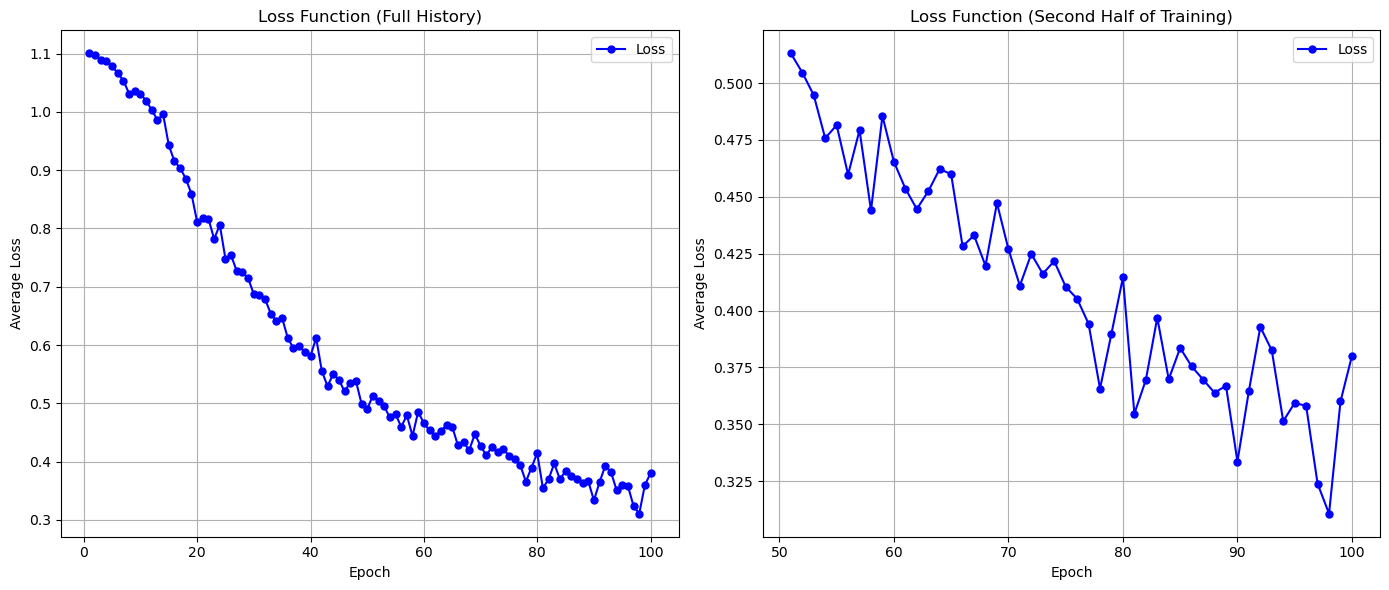

In [41]:
trainer4.plot_training_history()

#### Оценка

In [42]:
trainer4.evaluate(cifar100_004)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9291    0.9960    0.9614       500
  chimpanzee     0.9643    0.9180    0.9406       500
    mushroom     0.9447    0.9220    0.9332       500

    accuracy                         0.9453      1500
   macro avg     0.9460    0.9453    0.9451      1500
weighted avg     0.9460    0.9453    0.9451      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.7350    0.8600    0.7926       100
  chimpanzee     0.8375    0.6700    0.7444       100
    mushroom     0.8155    0.8400    0.8276       100

    accuracy                         0.7900       300
   macro avg     0.7960    0.7900    0.7882       300
weighted avg     0.7960    0.7900    0.7882       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [43]:
trainer4.save_model(cifar100_004)

Model saved as: cifar100_c0376eb0-b447-40e3-b8e2-ecb9adc93cb4.onnx
Model UUID: c0376eb0-b447-40e3-b8e2-ecb9adc93cb4


### Эксперимент №5

#### Гиперпараметры

In [44]:
batch_size=2**5
epochs=1000
criterion=nn.NLLLoss()
lr_rate = 1e-4
hidden_layers=[2**5, 2**7, 2**10, 2**7, 2**5]

#### Инициализация модели

In [45]:
%%time
trainer5 = CIFAR100Trainer(CLASSES, batch_size, lr_rate, criterion, experiment_name='cifar100_005')

Используемое устройство: cuda
CPU times: user 173 ms, sys: 281 ms, total: 454 ms
Wall time: 323 ms


In [46]:
%%time
cifar100_005 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_prob=0.5, 
    num_classes=CLASSES.__len__()
)

CPU times: user 27.4 ms, sys: 2.18 ms, total: 29.6 ms
Wall time: 3.62 ms


In [47]:
# Инициализация SummaryWriter
writer = SummaryWriter(log_dir=f'logs/cifar100_005')

# Визуализация графа
dummy_input = torch.randn(1, 32, 32, CLASSES.__len__())  # Размер входа для CIFAR100
writer.add_graph(cifar100_005, dummy_input)

# Закройте SummaryWriter
writer.close()

#### Информация о модели

In [48]:
cifar100_005

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=1024, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=128, out_features=32, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=32, out_features=3, bias=True)
  )
)

#### Обучение

In [49]:
%%time
trainer5.train(cifar100_005, epochs)

Epoch 1/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 257.13batch/s, loss=1.069860]


Epoch: 1/1000, Loss: 1.093691


Epoch 2/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 247.12batch/s, loss=1.061446]


Epoch: 2/1000, Loss: 1.076584


Epoch 3/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 235.40batch/s, loss=1.070924]


Epoch: 3/1000, Loss: 1.064012


Epoch 4/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 211.08batch/s, loss=1.078809]


Epoch: 4/1000, Loss: 1.037191


Epoch 5/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 208.68batch/s, loss=0.864756]


Epoch: 5/1000, Loss: 1.005484


Epoch 6/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 235.96batch/s, loss=0.856889]


Epoch: 6/1000, Loss: 0.941984


Epoch 7/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 241.24batch/s, loss=0.793705]


Epoch: 7/1000, Loss: 0.887789


Epoch 8/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 229.66batch/s, loss=0.773331]


Epoch: 8/1000, Loss: 0.848465


Epoch 9/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 213.39batch/s, loss=0.779426]


Epoch: 9/1000, Loss: 0.804737


Epoch 10/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 217.88batch/s, loss=0.803894]


Epoch: 10/1000, Loss: 0.768150


Epoch 11/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 190.91batch/s, loss=0.848242]


Epoch: 11/1000, Loss: 0.712995


Epoch 12/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 231.15batch/s, loss=0.544251]


Epoch: 12/1000, Loss: 0.696173


Epoch 13/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 224.15batch/s, loss=0.852192]


Epoch: 13/1000, Loss: 0.681741


Epoch 14/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 222.75batch/s, loss=0.603218]


Epoch: 14/1000, Loss: 0.669116


Epoch 15/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 220.16batch/s, loss=0.895329]


Epoch: 15/1000, Loss: 0.657038


Epoch 16/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 278.13batch/s, loss=0.491441]


Epoch: 16/1000, Loss: 0.645840


Epoch 17/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 266.35batch/s, loss=0.658634]


Epoch: 17/1000, Loss: 0.659816


Epoch 18/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 251.63batch/s, loss=0.384653]


Epoch: 18/1000, Loss: 0.637154


Epoch 19/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 246.74batch/s, loss=0.750204]


Epoch: 19/1000, Loss: 0.614033


Epoch 20/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 260.35batch/s, loss=0.510335]


Epoch: 20/1000, Loss: 0.581378


Epoch 21/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 232.81batch/s, loss=0.511661]


Epoch: 21/1000, Loss: 0.582014


Epoch 22/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 250.49batch/s, loss=0.545779]


Epoch: 22/1000, Loss: 0.556747


Epoch 23/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 240.79batch/s, loss=0.435965]


Epoch: 23/1000, Loss: 0.545794


Epoch 24/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 187.69batch/s, loss=0.374867]


Epoch: 24/1000, Loss: 0.548323


Epoch 25/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 220.37batch/s, loss=0.435103]


Epoch: 25/1000, Loss: 0.531418


Epoch 26/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 213.52batch/s, loss=0.285394]


Epoch: 26/1000, Loss: 0.510981


Epoch 27/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 192.79batch/s, loss=0.600050]


Epoch: 27/1000, Loss: 0.510148


Epoch 28/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 167.52batch/s, loss=0.387265]


Epoch: 28/1000, Loss: 0.494095


Epoch 29/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 197.62batch/s, loss=0.436069]


Epoch: 29/1000, Loss: 0.462342


Epoch 30/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 217.04batch/s, loss=0.495233]


Epoch: 30/1000, Loss: 0.475974


Epoch 31/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 234.83batch/s, loss=0.427421]


Epoch: 31/1000, Loss: 0.482472


Epoch 32/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 181.92batch/s, loss=0.638201]


Epoch: 32/1000, Loss: 0.446170


Epoch 33/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 166.03batch/s, loss=0.323390]


Epoch: 33/1000, Loss: 0.470224


Epoch 34/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 189.01batch/s, loss=0.548544]


Epoch: 34/1000, Loss: 0.446524


Epoch 35/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 211.75batch/s, loss=0.468531]


Epoch: 35/1000, Loss: 0.456027


Epoch 36/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 253.21batch/s, loss=0.581780]


Epoch: 36/1000, Loss: 0.459482


Epoch 37/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 252.28batch/s, loss=0.540755]


Epoch: 37/1000, Loss: 0.442726


Epoch 38/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 260.08batch/s, loss=0.430415]


Epoch: 38/1000, Loss: 0.427932


Epoch 39/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 245.41batch/s, loss=0.202051]


Epoch: 39/1000, Loss: 0.430338


Epoch 40/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 244.39batch/s, loss=0.315490]


Epoch: 40/1000, Loss: 0.417103


Epoch 41/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 260.44batch/s, loss=0.350899]


Epoch: 41/1000, Loss: 0.405444


Epoch 42/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 231.58batch/s, loss=0.459563]


Epoch: 42/1000, Loss: 0.423966


Epoch 43/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 247.73batch/s, loss=0.298806]


Epoch: 43/1000, Loss: 0.395450


Epoch 44/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 249.88batch/s, loss=0.477063]


Epoch: 44/1000, Loss: 0.367509


Epoch 45/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 171.77batch/s, loss=0.195142]


Epoch: 45/1000, Loss: 0.403148


Epoch 46/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 249.63batch/s, loss=0.400089]


Epoch: 46/1000, Loss: 0.386141


Epoch 47/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 219.58batch/s, loss=0.422902]


Epoch: 47/1000, Loss: 0.381813


Epoch 48/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 249.33batch/s, loss=0.263872]


Epoch: 48/1000, Loss: 0.396207


Epoch 49/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 243.34batch/s, loss=0.405671]


Epoch: 49/1000, Loss: 0.361397


Epoch 50/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 244.01batch/s, loss=0.197121]


Epoch: 50/1000, Loss: 0.358034


Epoch 51/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 247.03batch/s, loss=0.183275]


Epoch: 51/1000, Loss: 0.356036


Epoch 52/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 243.68batch/s, loss=0.213920]


Epoch: 52/1000, Loss: 0.352176


Epoch 53/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 244.04batch/s, loss=0.243702]


Epoch: 53/1000, Loss: 0.339411


Epoch 54/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 242.81batch/s, loss=0.281649]


Epoch: 54/1000, Loss: 0.349071


Epoch 55/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 242.81batch/s, loss=0.225411]


Epoch: 55/1000, Loss: 0.339612


Epoch 56/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 227.77batch/s, loss=0.131199]


Epoch: 56/1000, Loss: 0.313581


Epoch 57/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 277.43batch/s, loss=0.474643]


Epoch: 57/1000, Loss: 0.323827


Epoch 58/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 258.68batch/s, loss=0.391621]


Epoch: 58/1000, Loss: 0.336577


Epoch 59/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 249.72batch/s, loss=0.379731]


Epoch: 59/1000, Loss: 0.318532


Epoch 60/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 262.39batch/s, loss=0.283580]


Epoch: 60/1000, Loss: 0.302503


Epoch 61/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 263.23batch/s, loss=0.393971]


Epoch: 61/1000, Loss: 0.313454


Epoch 62/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 244.91batch/s, loss=0.232198]


Epoch: 62/1000, Loss: 0.312896


Epoch 63/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 244.39batch/s, loss=0.770253]


Epoch: 63/1000, Loss: 0.321706


Epoch 64/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 242.10batch/s, loss=0.548395]


Epoch: 64/1000, Loss: 0.300388


Epoch 65/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 252.04batch/s, loss=0.497543]


Epoch: 65/1000, Loss: 0.311038


Epoch 66/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 256.22batch/s, loss=0.308175]


Epoch: 66/1000, Loss: 0.291707


Epoch 67/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 257.21batch/s, loss=0.449713]


Epoch: 67/1000, Loss: 0.337822


Epoch 68/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 248.29batch/s, loss=0.238826]


Epoch: 68/1000, Loss: 0.329763


Epoch 69/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 253.65batch/s, loss=0.184357]


Epoch: 69/1000, Loss: 0.271953


Epoch 70/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 251.11batch/s, loss=0.124733]


Epoch: 70/1000, Loss: 0.264010


Epoch 71/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 250.72batch/s, loss=0.207546]


Epoch: 71/1000, Loss: 0.283192


Epoch 72/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 254.21batch/s, loss=0.380701]


Epoch: 72/1000, Loss: 0.290880


Epoch 73/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 232.75batch/s, loss=0.413382]


Epoch: 73/1000, Loss: 0.291021


Epoch 74/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 291.49batch/s, loss=0.283932]


Epoch: 74/1000, Loss: 0.284077


Epoch 75/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 292.76batch/s, loss=0.200888]


Epoch: 75/1000, Loss: 0.282253


Epoch 76/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 289.93batch/s, loss=0.168431]


Epoch: 76/1000, Loss: 0.256427


Epoch 77/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 292.29batch/s, loss=0.290939]


Epoch: 77/1000, Loss: 0.263728


Epoch 78/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 269.99batch/s, loss=0.220911]


Epoch: 78/1000, Loss: 0.283593


Epoch 79/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 260.68batch/s, loss=0.256795]


Epoch: 79/1000, Loss: 0.274255


Epoch 80/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 281.64batch/s, loss=0.275524]


Epoch: 80/1000, Loss: 0.243615


Epoch 81/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 264.29batch/s, loss=0.242638]


Epoch: 81/1000, Loss: 0.269298


Epoch 82/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 249.12batch/s, loss=0.421690]


Epoch: 82/1000, Loss: 0.251672


Epoch 83/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 249.38batch/s, loss=0.107419]


Epoch: 83/1000, Loss: 0.261351


Epoch 84/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 252.40batch/s, loss=0.206589]


Epoch: 84/1000, Loss: 0.284947


Epoch 85/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 248.77batch/s, loss=0.092472]


Epoch: 85/1000, Loss: 0.276289


Epoch 86/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 251.21batch/s, loss=0.189648]


Epoch: 86/1000, Loss: 0.241281


Epoch 87/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 250.92batch/s, loss=0.113196]


Epoch: 87/1000, Loss: 0.240212


Epoch 88/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 249.11batch/s, loss=0.343815]


Epoch: 88/1000, Loss: 0.225001


Epoch 89/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 253.43batch/s, loss=0.126938]


Epoch: 89/1000, Loss: 0.229684


Epoch 90/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 252.13batch/s, loss=0.330461]


Epoch: 90/1000, Loss: 0.236800


Epoch 91/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 253.54batch/s, loss=0.235346]


Epoch: 91/1000, Loss: 0.219924


Epoch 92/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 240.19batch/s, loss=0.169294]


Epoch: 92/1000, Loss: 0.254358


Epoch 93/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 251.32batch/s, loss=0.257590]


Epoch: 93/1000, Loss: 0.235696


Epoch 94/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 247.56batch/s, loss=0.392370]


Epoch: 94/1000, Loss: 0.258640


Epoch 95/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 250.77batch/s, loss=0.202234]


Epoch: 95/1000, Loss: 0.256451


Epoch 96/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 239.85batch/s, loss=0.237012]


Epoch: 96/1000, Loss: 0.218501


Epoch 97/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 298.53batch/s, loss=0.288546]


Epoch: 97/1000, Loss: 0.236286


Epoch 98/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 297.71batch/s, loss=0.195581]


Epoch: 98/1000, Loss: 0.202490


Epoch 99/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 297.58batch/s, loss=0.245108]


Epoch: 99/1000, Loss: 0.244797


Epoch 100/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 298.93batch/s, loss=0.164009]


Epoch: 100/1000, Loss: 0.264102


Epoch 101/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 292.80batch/s, loss=0.267732]


Epoch: 101/1000, Loss: 0.253155


Epoch 102/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.71batch/s, loss=0.280639]


Epoch: 102/1000, Loss: 0.242772


Epoch 103/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.67batch/s, loss=0.302769]


Epoch: 103/1000, Loss: 0.248952


Epoch 104/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 200.02batch/s, loss=0.099760]


Epoch: 104/1000, Loss: 0.188362


Epoch 105/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.69batch/s, loss=0.234677]


Epoch: 105/1000, Loss: 0.194888


Epoch 106/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.18batch/s, loss=0.151794]


Epoch: 106/1000, Loss: 0.240912


Epoch 107/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.16batch/s, loss=0.123086]


Epoch: 107/1000, Loss: 0.196936


Epoch 108/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 214.59batch/s, loss=0.135887]


Epoch: 108/1000, Loss: 0.191351


Epoch 109/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.39batch/s, loss=0.155163]


Epoch: 109/1000, Loss: 0.183513


Epoch 110/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.10batch/s, loss=0.209997]


Epoch: 110/1000, Loss: 0.197279


Epoch 111/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.26batch/s, loss=0.195308]


Epoch: 111/1000, Loss: 0.185716


Epoch 112/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.25batch/s, loss=0.057131]


Epoch: 112/1000, Loss: 0.175316


Epoch 113/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 270.79batch/s, loss=0.102365]


Epoch: 113/1000, Loss: 0.191154


Epoch 114/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.82batch/s, loss=0.045767]


Epoch: 114/1000, Loss: 0.192499


Epoch 115/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.35batch/s, loss=0.041367]


Epoch: 115/1000, Loss: 0.235856


Epoch 116/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.96batch/s, loss=0.231137]


Epoch: 116/1000, Loss: 0.218064


Epoch 117/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.32batch/s, loss=0.414655]


Epoch: 117/1000, Loss: 0.199258


Epoch 118/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.44batch/s, loss=0.219275]


Epoch: 118/1000, Loss: 0.203511


Epoch 119/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.81batch/s, loss=0.484549]


Epoch: 119/1000, Loss: 0.214211


Epoch 120/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.38batch/s, loss=0.141979]


Epoch: 120/1000, Loss: 0.188899


Epoch 121/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.52batch/s, loss=0.103205]


Epoch: 121/1000, Loss: 0.198761


Epoch 122/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.40batch/s, loss=0.332614]


Epoch: 122/1000, Loss: 0.215920


Epoch 123/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.66batch/s, loss=0.166633]


Epoch: 123/1000, Loss: 0.185363


Epoch 124/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.40batch/s, loss=0.242862]


Epoch: 124/1000, Loss: 0.185667


Epoch 125/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.29batch/s, loss=0.208373]


Epoch: 125/1000, Loss: 0.193825


Epoch 126/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.28batch/s, loss=0.098031]


Epoch: 126/1000, Loss: 0.204844


Epoch 127/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.59batch/s, loss=0.094357]


Epoch: 127/1000, Loss: 0.200118


Epoch 128/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.96batch/s, loss=0.366148]


Epoch: 128/1000, Loss: 0.170190


Epoch 129/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.97batch/s, loss=0.344576]


Epoch: 129/1000, Loss: 0.167108


Epoch 130/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.94batch/s, loss=0.033772]


Epoch: 130/1000, Loss: 0.171018


Epoch 131/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.31batch/s, loss=0.036779]


Epoch: 131/1000, Loss: 0.174404


Epoch 132/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.94batch/s, loss=0.110471]


Epoch: 132/1000, Loss: 0.155312


Epoch 133/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.34batch/s, loss=0.093235]


Epoch: 133/1000, Loss: 0.173188


Epoch 134/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.47batch/s, loss=0.026862]


Epoch: 134/1000, Loss: 0.191637


Epoch 135/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.12batch/s, loss=0.175925]


Epoch: 135/1000, Loss: 0.186872


Epoch 136/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.54batch/s, loss=0.266909]


Epoch: 136/1000, Loss: 0.179090


Epoch 137/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.36batch/s, loss=0.236598]


Epoch: 137/1000, Loss: 0.193649


Epoch 138/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.97batch/s, loss=0.200606]


Epoch: 138/1000, Loss: 0.189353


Epoch 139/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 263.08batch/s, loss=0.196845]


Epoch: 139/1000, Loss: 0.185271


Epoch 140/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.36batch/s, loss=0.139269]


Epoch: 140/1000, Loss: 0.164660


Epoch 141/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 218.17batch/s, loss=0.158548]


Epoch: 141/1000, Loss: 0.175580


Epoch 142/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.26batch/s, loss=0.211713]


Epoch: 142/1000, Loss: 0.205201


Epoch 143/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.62batch/s, loss=0.299778]


Epoch: 143/1000, Loss: 0.164795


Epoch 144/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 207.76batch/s, loss=0.291973]


Epoch: 144/1000, Loss: 0.148534


Epoch 145/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 198.36batch/s, loss=0.064191]


Epoch: 145/1000, Loss: 0.167007


Epoch 146/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 226.03batch/s, loss=0.309780]


Epoch: 146/1000, Loss: 0.184140


Epoch 147/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 229.77batch/s, loss=0.149483]


Epoch: 147/1000, Loss: 0.149631


Epoch 148/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.69batch/s, loss=0.126508]


Epoch: 148/1000, Loss: 0.168605


Epoch 149/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.11batch/s, loss=0.339851]


Epoch: 149/1000, Loss: 0.183022


Epoch 150/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.58batch/s, loss=0.089054]


Epoch: 150/1000, Loss: 0.146913


Epoch 151/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.05batch/s, loss=0.177572]


Epoch: 151/1000, Loss: 0.203114


Epoch 152/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.93batch/s, loss=0.147879]


Epoch: 152/1000, Loss: 0.157394


Epoch 153/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.13batch/s, loss=0.077420]


Epoch: 153/1000, Loss: 0.156356


Epoch 154/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.47batch/s, loss=0.124990]


Epoch: 154/1000, Loss: 0.195048


Epoch 155/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 269.76batch/s, loss=0.353677]


Epoch: 155/1000, Loss: 0.141269


Epoch 156/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 268.17batch/s, loss=0.108483]


Epoch: 156/1000, Loss: 0.156705


Epoch 157/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.28batch/s, loss=0.140932]


Epoch: 157/1000, Loss: 0.199171


Epoch 158/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 270.18batch/s, loss=0.077292]


Epoch: 158/1000, Loss: 0.181541


Epoch 159/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.07batch/s, loss=0.183740]


Epoch: 159/1000, Loss: 0.167438


Epoch 160/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.49batch/s, loss=0.132887]


Epoch: 160/1000, Loss: 0.155008


Epoch 161/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.55batch/s, loss=0.058397]


Epoch: 161/1000, Loss: 0.134524


Epoch 162/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.41batch/s, loss=0.149624]


Epoch: 162/1000, Loss: 0.169129


Epoch 163/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.99batch/s, loss=0.086853]


Epoch: 163/1000, Loss: 0.147161


Epoch 164/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.32batch/s, loss=0.166635]


Epoch: 164/1000, Loss: 0.155934


Epoch 165/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.10batch/s, loss=0.060981]


Epoch: 165/1000, Loss: 0.116306


Epoch 166/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.82batch/s, loss=0.540277]


Epoch: 166/1000, Loss: 0.164279


Epoch 167/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.99batch/s, loss=0.076952]


Epoch: 167/1000, Loss: 0.156892


Epoch 168/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.87batch/s, loss=0.205582]


Epoch: 168/1000, Loss: 0.166680


Epoch 169/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.91batch/s, loss=0.367261]


Epoch: 169/1000, Loss: 0.159284


Epoch 170/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.52batch/s, loss=0.041882]


Epoch: 170/1000, Loss: 0.150207


Epoch 171/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.87batch/s, loss=0.255221]


Epoch: 171/1000, Loss: 0.130569


Epoch 172/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.43batch/s, loss=0.125204]


Epoch: 172/1000, Loss: 0.184591


Epoch 173/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.31batch/s, loss=0.118009]


Epoch: 173/1000, Loss: 0.154263


Epoch 174/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.96batch/s, loss=0.041436]


Epoch: 174/1000, Loss: 0.160983


Epoch 175/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 190.12batch/s, loss=0.134228]


Epoch: 175/1000, Loss: 0.152205


Epoch 176/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.62batch/s, loss=0.140569]


Epoch: 176/1000, Loss: 0.124115


Epoch 177/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.23batch/s, loss=0.128256]


Epoch: 177/1000, Loss: 0.120670


Epoch 178/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 267.25batch/s, loss=0.038542]


Epoch: 178/1000, Loss: 0.135990


Epoch 179/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.14batch/s, loss=0.166654]


Epoch: 179/1000, Loss: 0.152380


Epoch 180/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.57batch/s, loss=0.262346]


Epoch: 180/1000, Loss: 0.132818


Epoch 181/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.73batch/s, loss=0.399809]


Epoch: 181/1000, Loss: 0.156226


Epoch 182/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.99batch/s, loss=0.103510]


Epoch: 182/1000, Loss: 0.163865


Epoch 183/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.74batch/s, loss=0.106027]


Epoch: 183/1000, Loss: 0.153997


Epoch 184/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.73batch/s, loss=0.079466]


Epoch: 184/1000, Loss: 0.156224


Epoch 185/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.67batch/s, loss=0.074315]


Epoch: 185/1000, Loss: 0.144259


Epoch 186/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.56batch/s, loss=0.111656]


Epoch: 186/1000, Loss: 0.143727


Epoch 187/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.40batch/s, loss=0.306146]


Epoch: 187/1000, Loss: 0.167559


Epoch 188/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.78batch/s, loss=0.111287]


Epoch: 188/1000, Loss: 0.137261


Epoch 189/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.73batch/s, loss=0.060667]


Epoch: 189/1000, Loss: 0.137304


Epoch 190/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.76batch/s, loss=0.102817]


Epoch: 190/1000, Loss: 0.153464


Epoch 191/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 210.74batch/s, loss=0.097196]


Epoch: 191/1000, Loss: 0.130995


Epoch 192/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.52batch/s, loss=0.211013]


Epoch: 192/1000, Loss: 0.151435


Epoch 193/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.42batch/s, loss=0.214883]


Epoch: 193/1000, Loss: 0.157424


Epoch 194/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 202.01batch/s, loss=0.043089]


Epoch: 194/1000, Loss: 0.158323


Epoch 195/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 214.84batch/s, loss=0.108938]


Epoch: 195/1000, Loss: 0.106807


Epoch 196/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 230.49batch/s, loss=0.183994]


Epoch: 196/1000, Loss: 0.161893


Epoch 197/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 227.60batch/s, loss=0.069902]


Epoch: 197/1000, Loss: 0.149077


Epoch 198/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 227.28batch/s, loss=0.221479]


Epoch: 198/1000, Loss: 0.144292


Epoch 199/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.34batch/s, loss=0.067772]


Epoch: 199/1000, Loss: 0.135446


Epoch 200/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 276.63batch/s, loss=0.036003]


Epoch: 200/1000, Loss: 0.130698


Epoch 201/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 273.53batch/s, loss=0.147930]


Epoch: 201/1000, Loss: 0.131253


Epoch 202/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 298.79batch/s, loss=0.107426]


Epoch: 202/1000, Loss: 0.118107


Epoch 203/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 317.43batch/s, loss=0.159770]


Epoch: 203/1000, Loss: 0.143326


Epoch 204/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 322.95batch/s, loss=0.138914]


Epoch: 204/1000, Loss: 0.116025


Epoch 205/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 304.50batch/s, loss=0.027329]


Epoch: 205/1000, Loss: 0.113994


Epoch 206/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 313.64batch/s, loss=0.051052]


Epoch: 206/1000, Loss: 0.139612


Epoch 207/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 314.36batch/s, loss=0.008571]


Epoch: 207/1000, Loss: 0.123996


Epoch 208/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 303.48batch/s, loss=0.211003]


Epoch: 208/1000, Loss: 0.146135


Epoch 209/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 316.31batch/s, loss=0.165153]


Epoch: 209/1000, Loss: 0.144635


Epoch 210/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.45batch/s, loss=0.147728]


Epoch: 210/1000, Loss: 0.109392


Epoch 211/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.85batch/s, loss=0.176762]


Epoch: 211/1000, Loss: 0.146473


Epoch 212/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.58batch/s, loss=0.021119]


Epoch: 212/1000, Loss: 0.182146


Epoch 213/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 211.28batch/s, loss=0.326148]


Epoch: 213/1000, Loss: 0.151895


Epoch 214/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 275.89batch/s, loss=0.218842]


Epoch: 214/1000, Loss: 0.124946


Epoch 215/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 287.16batch/s, loss=0.091133]


Epoch: 215/1000, Loss: 0.109320


Epoch 216/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 212.13batch/s, loss=0.110685]


Epoch: 216/1000, Loss: 0.110807


Epoch 217/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.72batch/s, loss=0.050086]


Epoch: 217/1000, Loss: 0.123692


Epoch 218/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.10batch/s, loss=0.059103]


Epoch: 218/1000, Loss: 0.146850


Epoch 219/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 204.29batch/s, loss=0.290180]


Epoch: 219/1000, Loss: 0.125105


Epoch 220/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.34batch/s, loss=0.292686]


Epoch: 220/1000, Loss: 0.124335


Epoch 221/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.85batch/s, loss=0.030380]


Epoch: 221/1000, Loss: 0.106453


Epoch 222/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.68batch/s, loss=0.046532]


Epoch: 222/1000, Loss: 0.121440


Epoch 223/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.66batch/s, loss=0.153693]


Epoch: 223/1000, Loss: 0.150576


Epoch 224/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.06batch/s, loss=0.030776]


Epoch: 224/1000, Loss: 0.146013


Epoch 225/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.36batch/s, loss=0.052693]


Epoch: 225/1000, Loss: 0.127257


Epoch 226/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.66batch/s, loss=0.128159]


Epoch: 226/1000, Loss: 0.117489


Epoch 227/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.68batch/s, loss=0.056158]


Epoch: 227/1000, Loss: 0.132060


Epoch 228/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.47batch/s, loss=0.163654]


Epoch: 228/1000, Loss: 0.122306


Epoch 229/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.59batch/s, loss=0.106354]


Epoch: 229/1000, Loss: 0.132210


Epoch 230/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 263.92batch/s, loss=0.159087]


Epoch: 230/1000, Loss: 0.137567


Epoch 231/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.61batch/s, loss=0.040309]


Epoch: 231/1000, Loss: 0.109994


Epoch 232/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.82batch/s, loss=0.430025]


Epoch: 232/1000, Loss: 0.134899


Epoch 233/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.61batch/s, loss=0.199901]


Epoch: 233/1000, Loss: 0.109166


Epoch 234/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.76batch/s, loss=0.045676]


Epoch: 234/1000, Loss: 0.134697


Epoch 235/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.12batch/s, loss=0.047113]


Epoch: 235/1000, Loss: 0.141306


Epoch 236/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 227.64batch/s, loss=0.443366]


Epoch: 236/1000, Loss: 0.123147


Epoch 237/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.45batch/s, loss=0.093865]


Epoch: 237/1000, Loss: 0.116238


Epoch 238/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.23batch/s, loss=0.239214]


Epoch: 238/1000, Loss: 0.184828


Epoch 239/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.74batch/s, loss=0.384775]


Epoch: 239/1000, Loss: 0.168729


Epoch 240/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.83batch/s, loss=0.117437]


Epoch: 240/1000, Loss: 0.115437


Epoch 241/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.12batch/s, loss=0.162936]


Epoch: 241/1000, Loss: 0.131455


Epoch 242/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 216.80batch/s, loss=0.081504]


Epoch: 242/1000, Loss: 0.112096


Epoch 243/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.42batch/s, loss=0.413157]


Epoch: 243/1000, Loss: 0.127227


Epoch 244/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.61batch/s, loss=0.815701]


Epoch: 244/1000, Loss: 0.139216


Epoch 245/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 213.82batch/s, loss=0.226782]


Epoch: 245/1000, Loss: 0.145302


Epoch 246/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.27batch/s, loss=0.139804]


Epoch: 246/1000, Loss: 0.126615


Epoch 247/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.95batch/s, loss=0.259008]


Epoch: 247/1000, Loss: 0.116493


Epoch 248/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.82batch/s, loss=0.041149]


Epoch: 248/1000, Loss: 0.121225


Epoch 249/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 234.26batch/s, loss=0.258839]


Epoch: 249/1000, Loss: 0.109828


Epoch 250/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 229.75batch/s, loss=0.212446]


Epoch: 250/1000, Loss: 0.104677


Epoch 251/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.12batch/s, loss=0.088450]


Epoch: 251/1000, Loss: 0.100679


Epoch 252/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.58batch/s, loss=0.149885]


Epoch: 252/1000, Loss: 0.124528


Epoch 253/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 287.94batch/s, loss=0.059007]


Epoch: 253/1000, Loss: 0.122330


Epoch 254/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 293.50batch/s, loss=0.262214]


Epoch: 254/1000, Loss: 0.116810


Epoch 255/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 223.44batch/s, loss=0.058748]


Epoch: 255/1000, Loss: 0.138828


Epoch 256/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 208.00batch/s, loss=0.069063]


Epoch: 256/1000, Loss: 0.114918


Epoch 257/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 203.32batch/s, loss=0.024172]


Epoch: 257/1000, Loss: 0.111065


Epoch 258/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 205.29batch/s, loss=0.069472]


Epoch: 258/1000, Loss: 0.115063


Epoch 259/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 197.41batch/s, loss=0.102496]


Epoch: 259/1000, Loss: 0.122810


Epoch 260/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 172.73batch/s, loss=0.028651]


Epoch: 260/1000, Loss: 0.090605


Epoch 261/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 201.14batch/s, loss=0.110362]


Epoch: 261/1000, Loss: 0.106574


Epoch 262/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.27batch/s, loss=0.030336]


Epoch: 262/1000, Loss: 0.119400


Epoch 263/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 189.33batch/s, loss=0.487499]


Epoch: 263/1000, Loss: 0.123461


Epoch 264/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 209.77batch/s, loss=0.017369]


Epoch: 264/1000, Loss: 0.119187


Epoch 265/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.74batch/s, loss=0.019161]


Epoch: 265/1000, Loss: 0.109937


Epoch 266/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 226.08batch/s, loss=0.019599]


Epoch: 266/1000, Loss: 0.133349


Epoch 267/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.33batch/s, loss=0.144135]


Epoch: 267/1000, Loss: 0.107089


Epoch 268/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.37batch/s, loss=0.018051]


Epoch: 268/1000, Loss: 0.111418


Epoch 269/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.86batch/s, loss=0.072509]


Epoch: 269/1000, Loss: 0.097149


Epoch 270/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 229.07batch/s, loss=0.102225]


Epoch: 270/1000, Loss: 0.097513


Epoch 271/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 278.86batch/s, loss=0.025176]


Epoch: 271/1000, Loss: 0.104201


Epoch 272/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 279.09batch/s, loss=0.067277]


Epoch: 272/1000, Loss: 0.088569


Epoch 273/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 287.17batch/s, loss=0.041661]


Epoch: 273/1000, Loss: 0.084574


Epoch 274/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 289.46batch/s, loss=0.166910]


Epoch: 274/1000, Loss: 0.101465


Epoch 275/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 287.18batch/s, loss=0.135997]


Epoch: 275/1000, Loss: 0.118226


Epoch 276/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 294.01batch/s, loss=0.094131]


Epoch: 276/1000, Loss: 0.180723


Epoch 277/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 288.15batch/s, loss=0.029356]


Epoch: 277/1000, Loss: 0.113167


Epoch 278/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.74batch/s, loss=0.008180]


Epoch: 278/1000, Loss: 0.099418


Epoch 279/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 223.55batch/s, loss=0.269894]


Epoch: 279/1000, Loss: 0.119397


Epoch 280/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 211.66batch/s, loss=0.027230]


Epoch: 280/1000, Loss: 0.103367


Epoch 281/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 211.48batch/s, loss=0.087923]


Epoch: 281/1000, Loss: 0.118200


Epoch 282/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 212.91batch/s, loss=0.081041]


Epoch: 282/1000, Loss: 0.085901


Epoch 283/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.53batch/s, loss=0.302181]


Epoch: 283/1000, Loss: 0.107303


Epoch 284/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.95batch/s, loss=0.062605]


Epoch: 284/1000, Loss: 0.125295


Epoch 285/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.76batch/s, loss=0.288440]


Epoch: 285/1000, Loss: 0.099874


Epoch 286/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 264.50batch/s, loss=0.079433]


Epoch: 286/1000, Loss: 0.104938


Epoch 287/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.85batch/s, loss=0.140008]


Epoch: 287/1000, Loss: 0.106705


Epoch 288/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.90batch/s, loss=0.467175]


Epoch: 288/1000, Loss: 0.093618


Epoch 289/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.67batch/s, loss=0.050235]


Epoch: 289/1000, Loss: 0.099257


Epoch 290/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 218.85batch/s, loss=0.089423]


Epoch: 290/1000, Loss: 0.113144


Epoch 291/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.72batch/s, loss=0.035315]


Epoch: 291/1000, Loss: 0.128243


Epoch 292/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.09batch/s, loss=0.136328]


Epoch: 292/1000, Loss: 0.123010


Epoch 293/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.66batch/s, loss=0.029764]


Epoch: 293/1000, Loss: 0.101066


Epoch 294/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.57batch/s, loss=0.011490]


Epoch: 294/1000, Loss: 0.096115


Epoch 295/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.52batch/s, loss=0.032528]


Epoch: 295/1000, Loss: 0.088186


Epoch 296/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.44batch/s, loss=0.006611]


Epoch: 296/1000, Loss: 0.101926


Epoch 297/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 295.29batch/s, loss=0.088863]


Epoch: 297/1000, Loss: 0.122698


Epoch 298/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.30batch/s, loss=0.271034]


Epoch: 298/1000, Loss: 0.115759


Epoch 299/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 182.92batch/s, loss=0.243188]


Epoch: 299/1000, Loss: 0.155553


Epoch 300/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.53batch/s, loss=0.057627]


Epoch: 300/1000, Loss: 0.098569


Epoch 301/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.39batch/s, loss=0.166876]


Epoch: 301/1000, Loss: 0.079531


Epoch 302/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 189.57batch/s, loss=0.071726]


Epoch: 302/1000, Loss: 0.110041


Epoch 303/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.47batch/s, loss=0.119099]


Epoch: 303/1000, Loss: 0.123424


Epoch 304/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.82batch/s, loss=0.110720]


Epoch: 304/1000, Loss: 0.116967


Epoch 305/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.72batch/s, loss=0.156175]


Epoch: 305/1000, Loss: 0.092100


Epoch 306/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.36batch/s, loss=0.030276]


Epoch: 306/1000, Loss: 0.076165


Epoch 307/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.10batch/s, loss=0.072140]


Epoch: 307/1000, Loss: 0.087986


Epoch 308/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.44batch/s, loss=0.039512]


Epoch: 308/1000, Loss: 0.097938


Epoch 309/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 275.47batch/s, loss=0.043348]


Epoch: 309/1000, Loss: 0.086645


Epoch 310/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 293.21batch/s, loss=0.040145]


Epoch: 310/1000, Loss: 0.110671


Epoch 311/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 294.62batch/s, loss=0.064587]


Epoch: 311/1000, Loss: 0.089068


Epoch 312/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 273.09batch/s, loss=0.030902]


Epoch: 312/1000, Loss: 0.089633


Epoch 313/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.13batch/s, loss=0.549942]


Epoch: 313/1000, Loss: 0.142668


Epoch 314/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.72batch/s, loss=0.024709]


Epoch: 314/1000, Loss: 0.160664


Epoch 315/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.91batch/s, loss=0.057935]


Epoch: 315/1000, Loss: 0.094909


Epoch 316/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.94batch/s, loss=0.006528]


Epoch: 316/1000, Loss: 0.127290


Epoch 317/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.12batch/s, loss=0.020236]


Epoch: 317/1000, Loss: 0.131748


Epoch 318/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 264.55batch/s, loss=0.088004]


Epoch: 318/1000, Loss: 0.108542


Epoch 319/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.33batch/s, loss=0.008910]


Epoch: 319/1000, Loss: 0.097766


Epoch 320/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 264.35batch/s, loss=0.174497]


Epoch: 320/1000, Loss: 0.117406


Epoch 321/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 278.69batch/s, loss=0.095573]


Epoch: 321/1000, Loss: 0.111148


Epoch 322/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 298.50batch/s, loss=0.021560]


Epoch: 322/1000, Loss: 0.089449


Epoch 323/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 264.30batch/s, loss=0.100272]


Epoch: 323/1000, Loss: 0.077536


Epoch 324/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.94batch/s, loss=0.265984]


Epoch: 324/1000, Loss: 0.100144


Epoch 325/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 263.42batch/s, loss=0.272872]


Epoch: 325/1000, Loss: 0.115864


Epoch 326/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 263.28batch/s, loss=0.102011]


Epoch: 326/1000, Loss: 0.098641


Epoch 327/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.80batch/s, loss=0.016160]


Epoch: 327/1000, Loss: 0.107784


Epoch 328/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.20batch/s, loss=0.134390]


Epoch: 328/1000, Loss: 0.113999


Epoch 329/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 281.79batch/s, loss=0.023047]


Epoch: 329/1000, Loss: 0.085086


Epoch 330/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 285.54batch/s, loss=0.038825]


Epoch: 330/1000, Loss: 0.109832


Epoch 331/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 286.11batch/s, loss=0.070079]


Epoch: 331/1000, Loss: 0.070633


Epoch 332/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 276.26batch/s, loss=0.047775]


Epoch: 332/1000, Loss: 0.107573


Epoch 333/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.24batch/s, loss=0.118160]


Epoch: 333/1000, Loss: 0.123390


Epoch 334/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 285.89batch/s, loss=0.037493]


Epoch: 334/1000, Loss: 0.131024


Epoch 335/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 283.77batch/s, loss=0.024172]


Epoch: 335/1000, Loss: 0.121116


Epoch 336/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 267.97batch/s, loss=0.108247]


Epoch: 336/1000, Loss: 0.095655


Epoch 337/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.35batch/s, loss=0.509523]


Epoch: 337/1000, Loss: 0.097395


Epoch 338/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.29batch/s, loss=0.153297]


Epoch: 338/1000, Loss: 0.107050


Epoch 339/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.83batch/s, loss=0.083734]


Epoch: 339/1000, Loss: 0.077892


Epoch 340/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.44batch/s, loss=0.074596]


Epoch: 340/1000, Loss: 0.093075


Epoch 341/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.09batch/s, loss=0.148914]


Epoch: 341/1000, Loss: 0.107508


Epoch 342/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.72batch/s, loss=0.239873]


Epoch: 342/1000, Loss: 0.138888


Epoch 343/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.76batch/s, loss=0.086154]


Epoch: 343/1000, Loss: 0.125987


Epoch 344/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.57batch/s, loss=0.095396]


Epoch: 344/1000, Loss: 0.105650


Epoch 345/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.25batch/s, loss=0.047856]


Epoch: 345/1000, Loss: 0.089953


Epoch 346/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.09batch/s, loss=0.120931]


Epoch: 346/1000, Loss: 0.099318


Epoch 347/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.21batch/s, loss=0.634219]


Epoch: 347/1000, Loss: 0.134748


Epoch 348/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.11batch/s, loss=0.088050]


Epoch: 348/1000, Loss: 0.107763


Epoch 349/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 210.67batch/s, loss=0.129645]


Epoch: 349/1000, Loss: 0.117531


Epoch 350/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 173.84batch/s, loss=0.122165]


Epoch: 350/1000, Loss: 0.131635


Epoch 351/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 208.80batch/s, loss=0.056750]


Epoch: 351/1000, Loss: 0.093602


Epoch 352/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 197.37batch/s, loss=0.096873]


Epoch: 352/1000, Loss: 0.092936


Epoch 353/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 211.14batch/s, loss=0.213338]


Epoch: 353/1000, Loss: 0.078133


Epoch 354/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 210.87batch/s, loss=0.129084]


Epoch: 354/1000, Loss: 0.086725


Epoch 355/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 200.41batch/s, loss=0.124327]


Epoch: 355/1000, Loss: 0.060130


Epoch 356/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 207.31batch/s, loss=0.062343]


Epoch: 356/1000, Loss: 0.081501


Epoch 357/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 195.26batch/s, loss=0.051112]


Epoch: 357/1000, Loss: 0.074469


Epoch 358/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 188.68batch/s, loss=0.142970]


Epoch: 358/1000, Loss: 0.127191


Epoch 359/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 202.90batch/s, loss=0.248180]


Epoch: 359/1000, Loss: 0.137383


Epoch 360/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 209.69batch/s, loss=0.038569]


Epoch: 360/1000, Loss: 0.114924


Epoch 361/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 171.57batch/s, loss=0.050165]


Epoch: 361/1000, Loss: 0.071264


Epoch 362/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.26batch/s, loss=0.062530]


Epoch: 362/1000, Loss: 0.089613


Epoch 363/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.35batch/s, loss=0.081518]


Epoch: 363/1000, Loss: 0.086394


Epoch 364/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 192.52batch/s, loss=0.019861]


Epoch: 364/1000, Loss: 0.086975


Epoch 365/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.46batch/s, loss=0.024922]


Epoch: 365/1000, Loss: 0.126782


Epoch 366/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 214.60batch/s, loss=0.174385]


Epoch: 366/1000, Loss: 0.118436


Epoch 367/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 226.78batch/s, loss=0.146163]


Epoch: 367/1000, Loss: 0.092576


Epoch 368/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 215.06batch/s, loss=0.109551]


Epoch: 368/1000, Loss: 0.104323


Epoch 369/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.04batch/s, loss=0.084539]


Epoch: 369/1000, Loss: 0.087600


Epoch 370/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 223.99batch/s, loss=0.017082]


Epoch: 370/1000, Loss: 0.084822


Epoch 371/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 229.22batch/s, loss=0.037012]


Epoch: 371/1000, Loss: 0.056189


Epoch 372/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.44batch/s, loss=0.019705]


Epoch: 372/1000, Loss: 0.074946


Epoch 373/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.84batch/s, loss=0.186195]


Epoch: 373/1000, Loss: 0.103784


Epoch 374/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.52batch/s, loss=0.020934]


Epoch: 374/1000, Loss: 0.099531


Epoch 375/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 228.78batch/s, loss=0.085607]


Epoch: 375/1000, Loss: 0.121154


Epoch 376/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 234.12batch/s, loss=0.100066]


Epoch: 376/1000, Loss: 0.110455


Epoch 377/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 268.30batch/s, loss=0.072135]


Epoch: 377/1000, Loss: 0.092009


Epoch 378/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 281.44batch/s, loss=0.053396]


Epoch: 378/1000, Loss: 0.153435


Epoch 379/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 279.79batch/s, loss=0.088967]


Epoch: 379/1000, Loss: 0.096429


Epoch 380/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.10batch/s, loss=0.492525]


Epoch: 380/1000, Loss: 0.098474


Epoch 381/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.05batch/s, loss=0.032322]


Epoch: 381/1000, Loss: 0.072096


Epoch 382/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.31batch/s, loss=0.178964]


Epoch: 382/1000, Loss: 0.106077


Epoch 383/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.42batch/s, loss=0.041048]


Epoch: 383/1000, Loss: 0.100110


Epoch 384/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 277.48batch/s, loss=0.087081]


Epoch: 384/1000, Loss: 0.087214


Epoch 385/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 275.75batch/s, loss=0.032809]


Epoch: 385/1000, Loss: 0.090104


Epoch 386/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 283.45batch/s, loss=0.046955]


Epoch: 386/1000, Loss: 0.116418


Epoch 387/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 278.97batch/s, loss=0.083382]


Epoch: 387/1000, Loss: 0.101698


Epoch 388/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 279.72batch/s, loss=0.078160]


Epoch: 388/1000, Loss: 0.081309


Epoch 389/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 285.71batch/s, loss=0.016682]


Epoch: 389/1000, Loss: 0.102886


Epoch 390/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 278.57batch/s, loss=0.051438]


Epoch: 390/1000, Loss: 0.090984


Epoch 391/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 276.69batch/s, loss=0.062583]


Epoch: 391/1000, Loss: 0.086981


Epoch 392/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 282.30batch/s, loss=0.223600]


Epoch: 392/1000, Loss: 0.094146


Epoch 393/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 280.06batch/s, loss=0.025341]


Epoch: 393/1000, Loss: 0.094804


Epoch 394/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 280.91batch/s, loss=0.024362]


Epoch: 394/1000, Loss: 0.131551


Epoch 395/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 288.50batch/s, loss=0.109541]


Epoch: 395/1000, Loss: 0.090822


Epoch 396/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 281.02batch/s, loss=0.016698]


Epoch: 396/1000, Loss: 0.118792


Epoch 397/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 277.46batch/s, loss=0.120397]


Epoch: 397/1000, Loss: 0.120031


Epoch 398/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 272.58batch/s, loss=0.265573]


Epoch: 398/1000, Loss: 0.099852


Epoch 399/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 273.67batch/s, loss=0.140424]


Epoch: 399/1000, Loss: 0.115170


Epoch 400/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 279.26batch/s, loss=0.023359]


Epoch: 400/1000, Loss: 0.096040


Epoch 401/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 277.41batch/s, loss=0.017510]


Epoch: 401/1000, Loss: 0.108279


Epoch 402/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.33batch/s, loss=0.183735]


Epoch: 402/1000, Loss: 0.090423


Epoch 403/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.26batch/s, loss=0.171246]


Epoch: 403/1000, Loss: 0.078781


Epoch 404/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.97batch/s, loss=0.058473]


Epoch: 404/1000, Loss: 0.078635


Epoch 405/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.82batch/s, loss=0.073968]


Epoch: 405/1000, Loss: 0.097279


Epoch 406/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.63batch/s, loss=0.033507]


Epoch: 406/1000, Loss: 0.076694


Epoch 407/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.77batch/s, loss=0.138190]


Epoch: 407/1000, Loss: 0.089414


Epoch 408/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.80batch/s, loss=0.026485]


Epoch: 408/1000, Loss: 0.096560


Epoch 409/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.07batch/s, loss=0.034557]


Epoch: 409/1000, Loss: 0.101534


Epoch 410/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.33batch/s, loss=0.028383]


Epoch: 410/1000, Loss: 0.091334


Epoch 411/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 214.43batch/s, loss=0.228510]


Epoch: 411/1000, Loss: 0.093646


Epoch 412/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 226.26batch/s, loss=0.100671]


Epoch: 412/1000, Loss: 0.111287


Epoch 413/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.50batch/s, loss=0.006722]


Epoch: 413/1000, Loss: 0.093002


Epoch 414/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.23batch/s, loss=0.156678]


Epoch: 414/1000, Loss: 0.151402


Epoch 415/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 212.27batch/s, loss=0.107330]


Epoch: 415/1000, Loss: 0.123044


Epoch 416/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 228.67batch/s, loss=0.045659]


Epoch: 416/1000, Loss: 0.094131


Epoch 417/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 212.25batch/s, loss=0.205417]


Epoch: 417/1000, Loss: 0.094516


Epoch 418/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 214.11batch/s, loss=0.235788]


Epoch: 418/1000, Loss: 0.098013


Epoch 419/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 208.53batch/s, loss=0.049498]


Epoch: 419/1000, Loss: 0.074807


Epoch 420/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.79batch/s, loss=0.080915]


Epoch: 420/1000, Loss: 0.058457


Epoch 421/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 263.58batch/s, loss=0.274898]


Epoch: 421/1000, Loss: 0.081635


Epoch 422/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.86batch/s, loss=0.085423]


Epoch: 422/1000, Loss: 0.123604


Epoch 423/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.66batch/s, loss=0.016875]


Epoch: 423/1000, Loss: 0.090198


Epoch 424/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.58batch/s, loss=0.022950]


Epoch: 424/1000, Loss: 0.096237


Epoch 425/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.13batch/s, loss=0.012799]


Epoch: 425/1000, Loss: 0.074364


Epoch 426/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.93batch/s, loss=0.033853]


Epoch: 426/1000, Loss: 0.074379


Epoch 427/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 203.44batch/s, loss=0.055528]


Epoch: 427/1000, Loss: 0.066960


Epoch 428/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 228.20batch/s, loss=0.091239]


Epoch: 428/1000, Loss: 0.095072


Epoch 429/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.27batch/s, loss=0.009908]


Epoch: 429/1000, Loss: 0.131953


Epoch 430/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.68batch/s, loss=0.026044]


Epoch: 430/1000, Loss: 0.111657


Epoch 431/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 264.89batch/s, loss=0.105566]


Epoch: 431/1000, Loss: 0.110172


Epoch 432/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 215.58batch/s, loss=0.005211]


Epoch: 432/1000, Loss: 0.084227


Epoch 433/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 229.47batch/s, loss=0.053047]


Epoch: 433/1000, Loss: 0.084292


Epoch 434/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 223.29batch/s, loss=0.145192]


Epoch: 434/1000, Loss: 0.088293


Epoch 435/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.86batch/s, loss=0.024087]


Epoch: 435/1000, Loss: 0.105223


Epoch 436/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 213.15batch/s, loss=0.025142]


Epoch: 436/1000, Loss: 0.076512


Epoch 437/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.13batch/s, loss=0.031767]


Epoch: 437/1000, Loss: 0.080224


Epoch 438/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 230.79batch/s, loss=0.022825]


Epoch: 438/1000, Loss: 0.070500


Epoch 439/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.03batch/s, loss=0.013899]


Epoch: 439/1000, Loss: 0.086063


Epoch 440/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.47batch/s, loss=0.158106]


Epoch: 440/1000, Loss: 0.103249


Epoch 441/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.55batch/s, loss=0.129909]


Epoch: 441/1000, Loss: 0.110172


Epoch 442/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.53batch/s, loss=0.078547]


Epoch: 442/1000, Loss: 0.122303


Epoch 443/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.73batch/s, loss=0.200602]


Epoch: 443/1000, Loss: 0.099196


Epoch 444/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 228.46batch/s, loss=0.036859]


Epoch: 444/1000, Loss: 0.103510


Epoch 445/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.15batch/s, loss=0.180408]


Epoch: 445/1000, Loss: 0.084451


Epoch 446/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.89batch/s, loss=0.057662]


Epoch: 446/1000, Loss: 0.077483


Epoch 447/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.73batch/s, loss=0.075503]


Epoch: 447/1000, Loss: 0.060803


Epoch 448/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.60batch/s, loss=0.049224]


Epoch: 448/1000, Loss: 0.093860


Epoch 449/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.39batch/s, loss=0.059115]


Epoch: 449/1000, Loss: 0.076542


Epoch 450/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.21batch/s, loss=0.035946]


Epoch: 450/1000, Loss: 0.076566


Epoch 451/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.13batch/s, loss=0.152847]


Epoch: 451/1000, Loss: 0.071445


Epoch 452/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 214.84batch/s, loss=0.107370]


Epoch: 452/1000, Loss: 0.074178


Epoch 453/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 216.37batch/s, loss=0.008833]


Epoch: 453/1000, Loss: 0.073844


Epoch 454/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 212.81batch/s, loss=0.203032]


Epoch: 454/1000, Loss: 0.078698


Epoch 455/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.01batch/s, loss=0.073563]


Epoch: 455/1000, Loss: 0.087103


Epoch 456/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 218.71batch/s, loss=0.401070]


Epoch: 456/1000, Loss: 0.087874


Epoch 457/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 228.23batch/s, loss=1.067702]


Epoch: 457/1000, Loss: 0.095161


Epoch 458/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.12batch/s, loss=0.040177]


Epoch: 458/1000, Loss: 0.079293


Epoch 459/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.36batch/s, loss=0.033464]


Epoch: 459/1000, Loss: 0.074100


Epoch 460/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 214.15batch/s, loss=0.188805]


Epoch: 460/1000, Loss: 0.067972


Epoch 461/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.80batch/s, loss=0.132020]


Epoch: 461/1000, Loss: 0.091887


Epoch 462/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.75batch/s, loss=0.046084]


Epoch: 462/1000, Loss: 0.077384


Epoch 463/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.09batch/s, loss=0.051119]


Epoch: 463/1000, Loss: 0.093611


Epoch 464/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.67batch/s, loss=0.010665]


Epoch: 464/1000, Loss: 0.093760


Epoch 465/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.41batch/s, loss=0.023897]


Epoch: 465/1000, Loss: 0.073109


Epoch 466/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.39batch/s, loss=0.016693]


Epoch: 466/1000, Loss: 0.071245


Epoch 467/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.38batch/s, loss=0.021951]


Epoch: 467/1000, Loss: 0.071579


Epoch 468/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.87batch/s, loss=0.039375]


Epoch: 468/1000, Loss: 0.067265


Epoch 469/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.68batch/s, loss=0.015841]


Epoch: 469/1000, Loss: 0.066253


Epoch 470/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.73batch/s, loss=0.067101]


Epoch: 470/1000, Loss: 0.071421


Epoch 471/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.31batch/s, loss=0.134177]


Epoch: 471/1000, Loss: 0.105220


Epoch 472/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.09batch/s, loss=0.189364]


Epoch: 472/1000, Loss: 0.114139


Epoch 473/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.50batch/s, loss=0.062771]


Epoch: 473/1000, Loss: 0.091637


Epoch 474/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.43batch/s, loss=0.038007]


Epoch: 474/1000, Loss: 0.075685


Epoch 475/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.94batch/s, loss=0.032376]


Epoch: 475/1000, Loss: 0.081053


Epoch 476/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.70batch/s, loss=0.103525]


Epoch: 476/1000, Loss: 0.072932


Epoch 477/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.75batch/s, loss=0.090455]


Epoch: 477/1000, Loss: 0.129349


Epoch 478/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.44batch/s, loss=0.018477]


Epoch: 478/1000, Loss: 0.115538


Epoch 479/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.46batch/s, loss=0.056692]


Epoch: 479/1000, Loss: 0.081187


Epoch 480/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.06batch/s, loss=0.067425]


Epoch: 480/1000, Loss: 0.073363


Epoch 481/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.23batch/s, loss=0.197960]


Epoch: 481/1000, Loss: 0.067994


Epoch 482/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 207.71batch/s, loss=0.037042]


Epoch: 482/1000, Loss: 0.073487


Epoch 483/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 209.82batch/s, loss=0.006119]


Epoch: 483/1000, Loss: 0.077923


Epoch 484/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 162.78batch/s, loss=0.030188]


Epoch: 484/1000, Loss: 0.083562


Epoch 485/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 234.20batch/s, loss=0.110888]


Epoch: 485/1000, Loss: 0.096000


Epoch 486/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.38batch/s, loss=0.071324]


Epoch: 486/1000, Loss: 0.091447


Epoch 487/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.88batch/s, loss=0.068749]


Epoch: 487/1000, Loss: 0.093776


Epoch 488/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.94batch/s, loss=0.085615]


Epoch: 488/1000, Loss: 0.097534


Epoch 489/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 213.93batch/s, loss=0.263604]


Epoch: 489/1000, Loss: 0.067096


Epoch 490/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.82batch/s, loss=0.014094]


Epoch: 490/1000, Loss: 0.098140


Epoch 491/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.10batch/s, loss=0.083894]


Epoch: 491/1000, Loss: 0.082214


Epoch 492/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 226.66batch/s, loss=0.094062]


Epoch: 492/1000, Loss: 0.082345


Epoch 493/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 228.58batch/s, loss=0.214560]


Epoch: 493/1000, Loss: 0.077287


Epoch 494/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 204.81batch/s, loss=0.007639]


Epoch: 494/1000, Loss: 0.088747


Epoch 495/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 210.39batch/s, loss=0.079886]


Epoch: 495/1000, Loss: 0.090817


Epoch 496/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 234.66batch/s, loss=0.021203]


Epoch: 496/1000, Loss: 0.068602


Epoch 497/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 226.19batch/s, loss=0.052996]


Epoch: 497/1000, Loss: 0.090143


Epoch 498/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 203.11batch/s, loss=0.115432]


Epoch: 498/1000, Loss: 0.077037


Epoch 499/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 203.75batch/s, loss=0.027088]


Epoch: 499/1000, Loss: 0.078078


Epoch 500/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 218.76batch/s, loss=0.039759]


Epoch: 500/1000, Loss: 0.084377


Epoch 501/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 206.71batch/s, loss=0.051598]


Epoch: 501/1000, Loss: 0.091622


Epoch 502/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 198.40batch/s, loss=0.006828]


Epoch: 502/1000, Loss: 0.089398


Epoch 503/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.28batch/s, loss=0.113074]


Epoch: 503/1000, Loss: 0.085261


Epoch 504/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.81batch/s, loss=0.113496]


Epoch: 504/1000, Loss: 0.088407


Epoch 505/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 234.86batch/s, loss=0.030959]


Epoch: 505/1000, Loss: 0.065098


Epoch 506/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.18batch/s, loss=0.033135]


Epoch: 506/1000, Loss: 0.073376


Epoch 507/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.22batch/s, loss=0.084866]

Epoch: 507/1000, Loss: 0.054860



Epoch 508/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.30batch/s, loss=0.094849]


Epoch: 508/1000, Loss: 0.073991


Epoch 509/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.26batch/s, loss=0.015872]


Epoch: 509/1000, Loss: 0.054690


Epoch 510/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.95batch/s, loss=0.015201]


Epoch: 510/1000, Loss: 0.053414


Epoch 511/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.51batch/s, loss=0.134712]


Epoch: 511/1000, Loss: 0.073873


Epoch 512/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 299.04batch/s, loss=0.211738]


Epoch: 512/1000, Loss: 0.094494


Epoch 513/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 279.83batch/s, loss=0.456703]


Epoch: 513/1000, Loss: 0.104679


Epoch 514/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 291.10batch/s, loss=0.186485]


Epoch: 514/1000, Loss: 0.118691


Epoch 515/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 298.11batch/s, loss=0.030373]


Epoch: 515/1000, Loss: 0.082376


Epoch 516/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 299.19batch/s, loss=0.057268]


Epoch: 516/1000, Loss: 0.104145


Epoch 517/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 295.07batch/s, loss=0.041528]


Epoch: 517/1000, Loss: 0.107965


Epoch 518/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 298.93batch/s, loss=0.082088]


Epoch: 518/1000, Loss: 0.080907


Epoch 519/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 298.09batch/s, loss=0.009501]


Epoch: 519/1000, Loss: 0.077302


Epoch 520/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 298.38batch/s, loss=0.215199]


Epoch: 520/1000, Loss: 0.070622


Epoch 521/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 298.50batch/s, loss=0.053594]


Epoch: 521/1000, Loss: 0.071020


Epoch 522/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 297.40batch/s, loss=0.229498]


Epoch: 522/1000, Loss: 0.095991


Epoch 523/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 297.25batch/s, loss=0.010152]


Epoch: 523/1000, Loss: 0.084757


Epoch 524/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 297.89batch/s, loss=0.002201]


Epoch: 524/1000, Loss: 0.083629


Epoch 525/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 295.00batch/s, loss=0.056830]


Epoch: 525/1000, Loss: 0.067868


Epoch 526/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 296.65batch/s, loss=0.057717]


Epoch: 526/1000, Loss: 0.092572


Epoch 527/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 298.84batch/s, loss=0.028843]


Epoch: 527/1000, Loss: 0.105627


Epoch 528/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 297.66batch/s, loss=0.123228]


Epoch: 528/1000, Loss: 0.095446


Epoch 529/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 298.40batch/s, loss=0.068397]


Epoch: 529/1000, Loss: 0.090515


Epoch 530/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 298.76batch/s, loss=0.069207]


Epoch: 530/1000, Loss: 0.116948


Epoch 531/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 294.90batch/s, loss=0.034147]


Epoch: 531/1000, Loss: 0.082664


Epoch 532/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.96batch/s, loss=0.039537]


Epoch: 532/1000, Loss: 0.062955


Epoch 533/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.09batch/s, loss=0.029924]


Epoch: 533/1000, Loss: 0.073080


Epoch 534/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.40batch/s, loss=0.034199]


Epoch: 534/1000, Loss: 0.073694


Epoch 535/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.31batch/s, loss=0.060064]


Epoch: 535/1000, Loss: 0.105198


Epoch 536/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.53batch/s, loss=0.703358]


Epoch: 536/1000, Loss: 0.110833


Epoch 537/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.11batch/s, loss=0.080331]


Epoch: 537/1000, Loss: 0.069859


Epoch 538/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.81batch/s, loss=0.127618]


Epoch: 538/1000, Loss: 0.075053


Epoch 539/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 234.51batch/s, loss=0.013472]


Epoch: 539/1000, Loss: 0.087263


Epoch 540/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 270.06batch/s, loss=0.036428]


Epoch: 540/1000, Loss: 0.079490


Epoch 541/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 269.06batch/s, loss=0.118148]


Epoch: 541/1000, Loss: 0.076246


Epoch 542/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 209.07batch/s, loss=0.072602]


Epoch: 542/1000, Loss: 0.077914


Epoch 543/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.69batch/s, loss=0.186001]


Epoch: 543/1000, Loss: 0.115086


Epoch 544/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.07batch/s, loss=0.122820]


Epoch: 544/1000, Loss: 0.077129


Epoch 545/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.17batch/s, loss=0.221331]


Epoch: 545/1000, Loss: 0.072252


Epoch 546/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.21batch/s, loss=0.162921]


Epoch: 546/1000, Loss: 0.074508


Epoch 547/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.82batch/s, loss=0.063011]


Epoch: 547/1000, Loss: 0.078056


Epoch 548/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.46batch/s, loss=0.039083]


Epoch: 548/1000, Loss: 0.065466


Epoch 549/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.21batch/s, loss=0.081708]


Epoch: 549/1000, Loss: 0.087137


Epoch 550/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.65batch/s, loss=0.048460]


Epoch: 550/1000, Loss: 0.073700


Epoch 551/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.97batch/s, loss=0.054476]


Epoch: 551/1000, Loss: 0.079795


Epoch 552/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.50batch/s, loss=0.101100]


Epoch: 552/1000, Loss: 0.072796


Epoch 553/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.89batch/s, loss=0.008462]


Epoch: 553/1000, Loss: 0.075038


Epoch 554/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.97batch/s, loss=0.220825]


Epoch: 554/1000, Loss: 0.100965


Epoch 555/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.06batch/s, loss=0.172918]


Epoch: 555/1000, Loss: 0.083551


Epoch 556/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 215.51batch/s, loss=0.310933]


Epoch: 556/1000, Loss: 0.061652


Epoch 557/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.48batch/s, loss=0.290219]


Epoch: 557/1000, Loss: 0.065008


Epoch 558/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.31batch/s, loss=0.074145]


Epoch: 558/1000, Loss: 0.051208


Epoch 559/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.66batch/s, loss=0.013761]


Epoch: 559/1000, Loss: 0.065907


Epoch 560/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.91batch/s, loss=0.007930]


Epoch: 560/1000, Loss: 0.086969


Epoch 561/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.82batch/s, loss=0.044438]


Epoch: 561/1000, Loss: 0.082643


Epoch 562/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.75batch/s, loss=0.158897]


Epoch: 562/1000, Loss: 0.095162


Epoch 563/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.89batch/s, loss=0.096531]


Epoch: 563/1000, Loss: 0.092832


Epoch 564/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.34batch/s, loss=0.144633]


Epoch: 564/1000, Loss: 0.081419


Epoch 565/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.26batch/s, loss=0.147017]


Epoch: 565/1000, Loss: 0.065759


Epoch 566/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.14batch/s, loss=0.016917]


Epoch: 566/1000, Loss: 0.065929


Epoch 567/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.65batch/s, loss=0.028841]


Epoch: 567/1000, Loss: 0.075750


Epoch 568/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 211.01batch/s, loss=0.023471]


Epoch: 568/1000, Loss: 0.055969


Epoch 569/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.55batch/s, loss=0.025907]


Epoch: 569/1000, Loss: 0.073935


Epoch 570/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.95batch/s, loss=0.021332]


Epoch: 570/1000, Loss: 0.076210


Epoch 571/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 218.07batch/s, loss=0.021257]


Epoch: 571/1000, Loss: 0.071893


Epoch 572/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.10batch/s, loss=0.174189]


Epoch: 572/1000, Loss: 0.116720


Epoch 573/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.20batch/s, loss=0.012071]


Epoch: 573/1000, Loss: 0.085609


Epoch 574/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.68batch/s, loss=0.102845]


Epoch: 574/1000, Loss: 0.072435


Epoch 575/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 196.71batch/s, loss=0.093626]


Epoch: 575/1000, Loss: 0.097289


Epoch 576/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 164.69batch/s, loss=0.023423]


Epoch: 576/1000, Loss: 0.081972


Epoch 577/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.62batch/s, loss=0.004500]


Epoch: 577/1000, Loss: 0.056379


Epoch 578/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.03batch/s, loss=0.181185]


Epoch: 578/1000, Loss: 0.068322


Epoch 579/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.51batch/s, loss=0.014205]


Epoch: 579/1000, Loss: 0.084689


Epoch 580/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.53batch/s, loss=0.010745]


Epoch: 580/1000, Loss: 0.057534


Epoch 581/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.77batch/s, loss=0.088141]


Epoch: 581/1000, Loss: 0.048449


Epoch 582/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.11batch/s, loss=0.019794]


Epoch: 582/1000, Loss: 0.083276


Epoch 583/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.52batch/s, loss=0.025192]


Epoch: 583/1000, Loss: 0.094523


Epoch 584/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.61batch/s, loss=0.017578]


Epoch: 584/1000, Loss: 0.080603


Epoch 585/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.08batch/s, loss=0.332895]


Epoch: 585/1000, Loss: 0.067278


Epoch 586/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.60batch/s, loss=0.056200]


Epoch: 586/1000, Loss: 0.073352


Epoch 587/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.55batch/s, loss=0.078940]


Epoch: 587/1000, Loss: 0.093186


Epoch 588/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.89batch/s, loss=0.054310]


Epoch: 588/1000, Loss: 0.074745


Epoch 589/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.32batch/s, loss=0.008024]


Epoch: 589/1000, Loss: 0.081261


Epoch 590/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 267.64batch/s, loss=0.140211]


Epoch: 590/1000, Loss: 0.060121


Epoch 591/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.86batch/s, loss=0.019763]


Epoch: 591/1000, Loss: 0.077604


Epoch 592/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 269.58batch/s, loss=0.131438]


Epoch: 592/1000, Loss: 0.063160


Epoch 593/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 268.10batch/s, loss=0.061490]


Epoch: 593/1000, Loss: 0.075341


Epoch 594/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.54batch/s, loss=0.110174]


Epoch: 594/1000, Loss: 0.063693


Epoch 595/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.39batch/s, loss=0.001835]


Epoch: 595/1000, Loss: 0.078173


Epoch 596/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 269.42batch/s, loss=0.008019]


Epoch: 596/1000, Loss: 0.070292


Epoch 597/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.77batch/s, loss=0.037867]


Epoch: 597/1000, Loss: 0.067225


Epoch 598/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 271.98batch/s, loss=0.040489]


Epoch: 598/1000, Loss: 0.071229


Epoch 599/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 229.39batch/s, loss=0.278758]


Epoch: 599/1000, Loss: 0.075620


Epoch 600/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.89batch/s, loss=0.017448]


Epoch: 600/1000, Loss: 0.081305


Epoch 601/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.12batch/s, loss=0.107537]


Epoch: 601/1000, Loss: 0.077723


Epoch 602/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 205.35batch/s, loss=0.040988]


Epoch: 602/1000, Loss: 0.075111


Epoch 603/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 206.50batch/s, loss=0.060617]


Epoch: 603/1000, Loss: 0.070978


Epoch 604/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 226.78batch/s, loss=0.010880]


Epoch: 604/1000, Loss: 0.069421


Epoch 605/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.56batch/s, loss=0.026389]


Epoch: 605/1000, Loss: 0.104407


Epoch 606/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.11batch/s, loss=0.042474]


Epoch: 606/1000, Loss: 0.095185


Epoch 607/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.65batch/s, loss=0.013525]


Epoch: 607/1000, Loss: 0.080510


Epoch 608/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.79batch/s, loss=0.016976]


Epoch: 608/1000, Loss: 0.049569


Epoch 609/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.60batch/s, loss=0.106173]


Epoch: 609/1000, Loss: 0.086521


Epoch 610/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.26batch/s, loss=0.006806]


Epoch: 610/1000, Loss: 0.068035


Epoch 611/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.51batch/s, loss=0.022371]


Epoch: 611/1000, Loss: 0.073243


Epoch 612/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.85batch/s, loss=0.040392]


Epoch: 612/1000, Loss: 0.082516


Epoch 613/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.93batch/s, loss=0.002547]


Epoch: 613/1000, Loss: 0.052159


Epoch 614/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.18batch/s, loss=0.012025]


Epoch: 614/1000, Loss: 0.086979


Epoch 615/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.59batch/s, loss=0.097574]


Epoch: 615/1000, Loss: 0.121802


Epoch 616/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.33batch/s, loss=0.023989]


Epoch: 616/1000, Loss: 0.123689


Epoch 617/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.65batch/s, loss=0.056016]


Epoch: 617/1000, Loss: 0.070362


Epoch 618/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.96batch/s, loss=0.107541]


Epoch: 618/1000, Loss: 0.077188


Epoch 619/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 223.03batch/s, loss=0.074356]


Epoch: 619/1000, Loss: 0.071138


Epoch 620/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.67batch/s, loss=0.124437]


Epoch: 620/1000, Loss: 0.075134


Epoch 621/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.02batch/s, loss=0.017796]


Epoch: 621/1000, Loss: 0.091426


Epoch 622/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.08batch/s, loss=0.073827]


Epoch: 622/1000, Loss: 0.065445


Epoch 623/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.25batch/s, loss=0.369439]


Epoch: 623/1000, Loss: 0.096661


Epoch 624/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.06batch/s, loss=0.003775]


Epoch: 624/1000, Loss: 0.063709


Epoch 625/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.35batch/s, loss=0.044502]


Epoch: 625/1000, Loss: 0.086781


Epoch 626/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.17batch/s, loss=0.034038]


Epoch: 626/1000, Loss: 0.066472


Epoch 627/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 267.42batch/s, loss=0.021383]


Epoch: 627/1000, Loss: 0.056077


Epoch 628/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 269.51batch/s, loss=0.251256]


Epoch: 628/1000, Loss: 0.083440


Epoch 629/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.49batch/s, loss=0.064650]


Epoch: 629/1000, Loss: 0.090183


Epoch 630/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 302.05batch/s, loss=0.038859]


Epoch: 630/1000, Loss: 0.047754


Epoch 631/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.15batch/s, loss=0.119025]


Epoch: 631/1000, Loss: 0.076044


Epoch 632/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 226.30batch/s, loss=0.021254]


Epoch: 632/1000, Loss: 0.079598


Epoch 633/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.46batch/s, loss=0.007616]


Epoch: 633/1000, Loss: 0.068392


Epoch 634/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.36batch/s, loss=0.063417]


Epoch: 634/1000, Loss: 0.083918


Epoch 635/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 268.55batch/s, loss=0.007152]


Epoch: 635/1000, Loss: 0.052164


Epoch 636/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 289.01batch/s, loss=0.045615]


Epoch: 636/1000, Loss: 0.058958


Epoch 637/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 276.50batch/s, loss=0.079462]


Epoch: 637/1000, Loss: 0.076227


Epoch 638/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 294.43batch/s, loss=0.011002]


Epoch: 638/1000, Loss: 0.076576


Epoch 639/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 278.37batch/s, loss=0.030599]


Epoch: 639/1000, Loss: 0.067689


Epoch 640/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 275.06batch/s, loss=0.317914]


Epoch: 640/1000, Loss: 0.068877


Epoch 641/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.25batch/s, loss=0.179760]


Epoch: 641/1000, Loss: 0.080644


Epoch 642/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 273.75batch/s, loss=0.244810]


Epoch: 642/1000, Loss: 0.104726


Epoch 643/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 289.16batch/s, loss=0.144651]


Epoch: 643/1000, Loss: 0.077965


Epoch 644/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 268.41batch/s, loss=0.060793]


Epoch: 644/1000, Loss: 0.071262


Epoch 645/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 270.46batch/s, loss=0.014273]


Epoch: 645/1000, Loss: 0.063002


Epoch 646/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 278.79batch/s, loss=0.021547]


Epoch: 646/1000, Loss: 0.063430


Epoch 647/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 290.68batch/s, loss=0.185335]


Epoch: 647/1000, Loss: 0.057322


Epoch 648/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 285.16batch/s, loss=0.009823]


Epoch: 648/1000, Loss: 0.057566


Epoch 649/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 267.79batch/s, loss=0.054954]


Epoch: 649/1000, Loss: 0.075898


Epoch 650/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 276.80batch/s, loss=0.111869]


Epoch: 650/1000, Loss: 0.091478


Epoch 651/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 275.26batch/s, loss=0.069286]


Epoch: 651/1000, Loss: 0.075868


Epoch 652/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 273.15batch/s, loss=0.099004]


Epoch: 652/1000, Loss: 0.055791


Epoch 653/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 267.49batch/s, loss=0.049855]


Epoch: 653/1000, Loss: 0.069790


Epoch 654/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 279.94batch/s, loss=0.000120]


Epoch: 654/1000, Loss: 0.061023


Epoch 655/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.11batch/s, loss=0.025369]


Epoch: 655/1000, Loss: 0.055979


Epoch 656/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 230.03batch/s, loss=0.155351]


Epoch: 656/1000, Loss: 0.061755


Epoch 657/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 284.73batch/s, loss=0.001398]


Epoch: 657/1000, Loss: 0.046232


Epoch 658/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 282.34batch/s, loss=0.016553]


Epoch: 658/1000, Loss: 0.050997


Epoch 659/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 279.20batch/s, loss=0.017729]


Epoch: 659/1000, Loss: 0.060690


Epoch 660/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.80batch/s, loss=0.148989]


Epoch: 660/1000, Loss: 0.065199


Epoch 661/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.90batch/s, loss=0.023547]


Epoch: 661/1000, Loss: 0.074379


Epoch 662/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 264.57batch/s, loss=0.026527]


Epoch: 662/1000, Loss: 0.085080


Epoch 663/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.61batch/s, loss=0.024076]


Epoch: 663/1000, Loss: 0.122761


Epoch 664/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 282.12batch/s, loss=0.186922]


Epoch: 664/1000, Loss: 0.117559


Epoch 665/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 281.75batch/s, loss=0.066767]


Epoch: 665/1000, Loss: 0.078323


Epoch 666/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 286.70batch/s, loss=0.016033]


Epoch: 666/1000, Loss: 0.061454


Epoch 667/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 284.13batch/s, loss=0.015892]


Epoch: 667/1000, Loss: 0.051313


Epoch 668/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 285.20batch/s, loss=0.495495]


Epoch: 668/1000, Loss: 0.059060


Epoch 669/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.26batch/s, loss=0.018358]


Epoch: 669/1000, Loss: 0.055486


Epoch 670/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 274.29batch/s, loss=0.003510]


Epoch: 670/1000, Loss: 0.070185


Epoch 671/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 264.12batch/s, loss=0.099493]


Epoch: 671/1000, Loss: 0.066205


Epoch 672/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.42batch/s, loss=0.060949]


Epoch: 672/1000, Loss: 0.075579


Epoch 673/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 284.98batch/s, loss=0.127131]


Epoch: 673/1000, Loss: 0.056984


Epoch 674/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 286.50batch/s, loss=0.082753]


Epoch: 674/1000, Loss: 0.066319


Epoch 675/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 285.80batch/s, loss=0.076656]


Epoch: 675/1000, Loss: 0.063405


Epoch 676/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 273.55batch/s, loss=0.025320]


Epoch: 676/1000, Loss: 0.077425


Epoch 677/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.91batch/s, loss=0.105769]


Epoch: 677/1000, Loss: 0.079188


Epoch 678/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 267.57batch/s, loss=0.102177]


Epoch: 678/1000, Loss: 0.075065


Epoch 679/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.99batch/s, loss=0.137171]


Epoch: 679/1000, Loss: 0.149848


Epoch 680/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.37batch/s, loss=0.170585]


Epoch: 680/1000, Loss: 0.083585


Epoch 681/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.35batch/s, loss=0.063560]


Epoch: 681/1000, Loss: 0.074179


Epoch 682/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.12batch/s, loss=0.201506]


Epoch: 682/1000, Loss: 0.077245


Epoch 683/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.40batch/s, loss=0.222827]


Epoch: 683/1000, Loss: 0.093139


Epoch 684/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.47batch/s, loss=0.078873]


Epoch: 684/1000, Loss: 0.062857


Epoch 685/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.04batch/s, loss=0.248168]


Epoch: 685/1000, Loss: 0.075947


Epoch 686/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.39batch/s, loss=0.103689]


Epoch: 686/1000, Loss: 0.076945


Epoch 687/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.92batch/s, loss=0.069854]


Epoch: 687/1000, Loss: 0.045854


Epoch 688/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.75batch/s, loss=0.004081]


Epoch: 688/1000, Loss: 0.049146


Epoch 689/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.38batch/s, loss=0.033371]


Epoch: 689/1000, Loss: 0.070633


Epoch 690/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.20batch/s, loss=0.128545]


Epoch: 690/1000, Loss: 0.081688


Epoch 691/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.66batch/s, loss=0.072354]


Epoch: 691/1000, Loss: 0.099439


Epoch 692/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 207.03batch/s, loss=0.150633]


Epoch: 692/1000, Loss: 0.074392


Epoch 693/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 203.81batch/s, loss=0.078183]


Epoch: 693/1000, Loss: 0.065250


Epoch 694/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 202.27batch/s, loss=0.052804]


Epoch: 694/1000, Loss: 0.039893


Epoch 695/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 205.84batch/s, loss=0.066399]


Epoch: 695/1000, Loss: 0.072649


Epoch 696/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 213.84batch/s, loss=0.075373]


Epoch: 696/1000, Loss: 0.055056


Epoch 697/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 208.40batch/s, loss=0.016545]


Epoch: 697/1000, Loss: 0.077441


Epoch 698/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 207.20batch/s, loss=0.026802]


Epoch: 698/1000, Loss: 0.056355


Epoch 699/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 208.84batch/s, loss=0.027009]


Epoch: 699/1000, Loss: 0.060455


Epoch 700/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 201.40batch/s, loss=0.017419]


Epoch: 700/1000, Loss: 0.057579


Epoch 701/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 190.83batch/s, loss=0.018221]


Epoch: 701/1000, Loss: 0.049848


Epoch 702/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 206.90batch/s, loss=0.073967]


Epoch: 702/1000, Loss: 0.074629


Epoch 703/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 175.60batch/s, loss=0.009498]


Epoch: 703/1000, Loss: 0.089139


Epoch 704/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 202.74batch/s, loss=0.037501]


Epoch: 704/1000, Loss: 0.090631


Epoch 705/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 206.79batch/s, loss=0.091026]


Epoch: 705/1000, Loss: 0.082135


Epoch 706/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.24batch/s, loss=0.216668]


Epoch: 706/1000, Loss: 0.086272


Epoch 707/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 198.18batch/s, loss=0.003531]


Epoch: 707/1000, Loss: 0.052437


Epoch 708/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.17batch/s, loss=0.074409]


Epoch: 708/1000, Loss: 0.070533


Epoch 709/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.16batch/s, loss=0.016534]


Epoch: 709/1000, Loss: 0.059374


Epoch 710/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.30batch/s, loss=0.092073]


Epoch: 710/1000, Loss: 0.066894


Epoch 711/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 292.30batch/s, loss=0.023209]


Epoch: 711/1000, Loss: 0.079211


Epoch 712/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 272.80batch/s, loss=0.076952]


Epoch: 712/1000, Loss: 0.083426


Epoch 713/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.16batch/s, loss=0.153405]


Epoch: 713/1000, Loss: 0.074334


Epoch 714/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.78batch/s, loss=0.067415]


Epoch: 714/1000, Loss: 0.063572


Epoch 715/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.58batch/s, loss=0.017528]


Epoch: 715/1000, Loss: 0.061491


Epoch 716/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 204.02batch/s, loss=0.016514]


Epoch: 716/1000, Loss: 0.071527


Epoch 717/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.53batch/s, loss=0.138987]


Epoch: 717/1000, Loss: 0.060326


Epoch 718/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.12batch/s, loss=0.120207]


Epoch: 718/1000, Loss: 0.063993


Epoch 719/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 230.17batch/s, loss=0.046168]


Epoch: 719/1000, Loss: 0.055412


Epoch 720/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.32batch/s, loss=0.017724]


Epoch: 720/1000, Loss: 0.077290


Epoch 721/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.84batch/s, loss=0.016324]


Epoch: 721/1000, Loss: 0.075543


Epoch 722/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 230.04batch/s, loss=0.024335]


Epoch: 722/1000, Loss: 0.063229


Epoch 723/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.79batch/s, loss=0.001416]


Epoch: 723/1000, Loss: 0.079529


Epoch 724/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.03batch/s, loss=0.005446]


Epoch: 724/1000, Loss: 0.079004


Epoch 725/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.72batch/s, loss=0.099232]


Epoch: 725/1000, Loss: 0.083545


Epoch 726/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 223.54batch/s, loss=0.023950]


Epoch: 726/1000, Loss: 0.066403


Epoch 727/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.18batch/s, loss=0.084332]


Epoch: 727/1000, Loss: 0.084902


Epoch 728/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.12batch/s, loss=0.099975]


Epoch: 728/1000, Loss: 0.076847


Epoch 729/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.01batch/s, loss=0.088977]


Epoch: 729/1000, Loss: 0.070478


Epoch 730/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 229.23batch/s, loss=0.028297]


Epoch: 730/1000, Loss: 0.072277


Epoch 731/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.11batch/s, loss=0.114049]


Epoch: 731/1000, Loss: 0.060570


Epoch 732/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 271.80batch/s, loss=0.014813]


Epoch: 732/1000, Loss: 0.055478


Epoch 733/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 273.85batch/s, loss=0.039358]


Epoch: 733/1000, Loss: 0.058833


Epoch 734/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 276.90batch/s, loss=0.038178]


Epoch: 734/1000, Loss: 0.054805


Epoch 735/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 272.92batch/s, loss=0.031661]


Epoch: 735/1000, Loss: 0.082340


Epoch 736/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.24batch/s, loss=0.010539]


Epoch: 736/1000, Loss: 0.070520


Epoch 737/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.78batch/s, loss=0.108676]


Epoch: 737/1000, Loss: 0.061927


Epoch 738/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.84batch/s, loss=0.033038]


Epoch: 738/1000, Loss: 0.065737


Epoch 739/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.39batch/s, loss=0.079266]


Epoch: 739/1000, Loss: 0.070387


Epoch 740/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.84batch/s, loss=0.014692]


Epoch: 740/1000, Loss: 0.065467


Epoch 741/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.09batch/s, loss=0.022521]


Epoch: 741/1000, Loss: 0.083677


Epoch 742/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.60batch/s, loss=0.092328]


Epoch: 742/1000, Loss: 0.077145


Epoch 743/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.42batch/s, loss=0.059485]


Epoch: 743/1000, Loss: 0.072007


Epoch 744/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.12batch/s, loss=0.015648]


Epoch: 744/1000, Loss: 0.058731


Epoch 745/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 272.32batch/s, loss=0.004602]


Epoch: 745/1000, Loss: 0.065734


Epoch 746/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.06batch/s, loss=0.064291]


Epoch: 746/1000, Loss: 0.047597


Epoch 747/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.14batch/s, loss=0.015278]


Epoch: 747/1000, Loss: 0.059687


Epoch 748/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 208.57batch/s, loss=0.008193]


Epoch: 748/1000, Loss: 0.053272


Epoch 749/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 211.87batch/s, loss=0.029971]


Epoch: 749/1000, Loss: 0.067556


Epoch 750/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 285.22batch/s, loss=0.091338]


Epoch: 750/1000, Loss: 0.063222


Epoch 751/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.09batch/s, loss=0.015912]


Epoch: 751/1000, Loss: 0.090099


Epoch 752/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.37batch/s, loss=0.084345]


Epoch: 752/1000, Loss: 0.079881


Epoch 753/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.11batch/s, loss=0.030556]


Epoch: 753/1000, Loss: 0.063664


Epoch 754/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.44batch/s, loss=0.227550]


Epoch: 754/1000, Loss: 0.080444


Epoch 755/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.60batch/s, loss=0.015478]


Epoch: 755/1000, Loss: 0.054660


Epoch 756/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.04batch/s, loss=0.027060]


Epoch: 756/1000, Loss: 0.071982


Epoch 757/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 218.10batch/s, loss=0.074461]


Epoch: 757/1000, Loss: 0.051542


Epoch 758/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.11batch/s, loss=0.064045]


Epoch: 758/1000, Loss: 0.056559


Epoch 759/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 226.64batch/s, loss=0.014092]


Epoch: 759/1000, Loss: 0.063225


Epoch 760/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.29batch/s, loss=0.005841]


Epoch: 760/1000, Loss: 0.049466


Epoch 761/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.76batch/s, loss=0.004170]


Epoch: 761/1000, Loss: 0.050777


Epoch 762/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.84batch/s, loss=0.006852]


Epoch: 762/1000, Loss: 0.034970


Epoch 763/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 264.61batch/s, loss=0.029826]


Epoch: 763/1000, Loss: 0.050186


Epoch 764/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.34batch/s, loss=0.070244]


Epoch: 764/1000, Loss: 0.133922


Epoch 765/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 268.57batch/s, loss=0.119428]


Epoch: 765/1000, Loss: 0.147706


Epoch 766/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 272.69batch/s, loss=0.145736]


Epoch: 766/1000, Loss: 0.094805


Epoch 767/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.12batch/s, loss=0.057290]


Epoch: 767/1000, Loss: 0.085137


Epoch 768/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.23batch/s, loss=0.084562]


Epoch: 768/1000, Loss: 0.075879


Epoch 769/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.76batch/s, loss=0.004471]


Epoch: 769/1000, Loss: 0.071028


Epoch 770/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.48batch/s, loss=0.014685]


Epoch: 770/1000, Loss: 0.085223


Epoch 771/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.84batch/s, loss=0.020551]


Epoch: 771/1000, Loss: 0.092574


Epoch 772/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 277.78batch/s, loss=0.022860]


Epoch: 772/1000, Loss: 0.055394


Epoch 773/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.62batch/s, loss=0.009695]


Epoch: 773/1000, Loss: 0.055407


Epoch 774/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 281.73batch/s, loss=0.000570]


Epoch: 774/1000, Loss: 0.064236


Epoch 775/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 226.89batch/s, loss=0.095983]


Epoch: 775/1000, Loss: 0.070627


Epoch 776/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.63batch/s, loss=0.239191]


Epoch: 776/1000, Loss: 0.054426


Epoch 777/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 214.55batch/s, loss=0.138069]


Epoch: 777/1000, Loss: 0.067205


Epoch 778/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.11batch/s, loss=0.065674]


Epoch: 778/1000, Loss: 0.068554


Epoch 779/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.15batch/s, loss=0.181150]


Epoch: 779/1000, Loss: 0.098870


Epoch 780/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.99batch/s, loss=0.119424]


Epoch: 780/1000, Loss: 0.066567


Epoch 781/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.25batch/s, loss=0.018224]


Epoch: 781/1000, Loss: 0.056178


Epoch 782/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.84batch/s, loss=0.063690]


Epoch: 782/1000, Loss: 0.069627


Epoch 783/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 223.84batch/s, loss=0.001403]


Epoch: 783/1000, Loss: 0.050976


Epoch 784/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.00batch/s, loss=0.133841]


Epoch: 784/1000, Loss: 0.061330


Epoch 785/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.77batch/s, loss=0.033456]


Epoch: 785/1000, Loss: 0.070538


Epoch 786/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 280.72batch/s, loss=0.073611]


Epoch: 786/1000, Loss: 0.084408


Epoch 787/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 281.35batch/s, loss=0.022988]


Epoch: 787/1000, Loss: 0.075702


Epoch 788/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.87batch/s, loss=0.047418]


Epoch: 788/1000, Loss: 0.081636


Epoch 789/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.11batch/s, loss=0.011421]


Epoch: 789/1000, Loss: 0.059267


Epoch 790/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.56batch/s, loss=0.008907]


Epoch: 790/1000, Loss: 0.035755


Epoch 791/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 267.52batch/s, loss=0.030315]


Epoch: 791/1000, Loss: 0.062240


Epoch 792/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.75batch/s, loss=0.011256]


Epoch: 792/1000, Loss: 0.061422


Epoch 793/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.82batch/s, loss=0.000487]


Epoch: 793/1000, Loss: 0.084307


Epoch 794/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.67batch/s, loss=0.055489]


Epoch: 794/1000, Loss: 0.064632


Epoch 795/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.95batch/s, loss=0.000764]


Epoch: 795/1000, Loss: 0.066665


Epoch 796/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.82batch/s, loss=0.095013]


Epoch: 796/1000, Loss: 0.072737


Epoch 797/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.37batch/s, loss=0.192944]


Epoch: 797/1000, Loss: 0.054570


Epoch 798/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.52batch/s, loss=0.041523]


Epoch: 798/1000, Loss: 0.064418


Epoch 799/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 212.69batch/s, loss=0.046599]


Epoch: 799/1000, Loss: 0.064825


Epoch 800/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.15batch/s, loss=0.015090]


Epoch: 800/1000, Loss: 0.056091


Epoch 801/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 263.66batch/s, loss=0.029877]


Epoch: 801/1000, Loss: 0.051355


Epoch 802/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 270.68batch/s, loss=0.058033]


Epoch: 802/1000, Loss: 0.054508


Epoch 803/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 271.70batch/s, loss=0.028877]


Epoch: 803/1000, Loss: 0.086659


Epoch 804/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 272.13batch/s, loss=0.012808]


Epoch: 804/1000, Loss: 0.072104


Epoch 805/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 268.41batch/s, loss=0.022202]


Epoch: 805/1000, Loss: 0.051349


Epoch 806/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.05batch/s, loss=0.006733]


Epoch: 806/1000, Loss: 0.053360


Epoch 807/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.48batch/s, loss=0.150728]


Epoch: 807/1000, Loss: 0.045995


Epoch 808/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.04batch/s, loss=0.080652]


Epoch: 808/1000, Loss: 0.051400


Epoch 809/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.03batch/s, loss=0.052268]


Epoch: 809/1000, Loss: 0.065103


Epoch 810/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 285.28batch/s, loss=0.283699]


Epoch: 810/1000, Loss: 0.085472


Epoch 811/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.61batch/s, loss=0.016817]


Epoch: 811/1000, Loss: 0.072527


Epoch 812/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.66batch/s, loss=0.016002]


Epoch: 812/1000, Loss: 0.085155


Epoch 813/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.21batch/s, loss=0.116923]


Epoch: 813/1000, Loss: 0.061036


Epoch 814/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.58batch/s, loss=0.043139]


Epoch: 814/1000, Loss: 0.072804


Epoch 815/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.20batch/s, loss=0.019853]


Epoch: 815/1000, Loss: 0.079843


Epoch 816/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.75batch/s, loss=0.100214]


Epoch: 816/1000, Loss: 0.050742


Epoch 817/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 275.09batch/s, loss=0.057038]


Epoch: 817/1000, Loss: 0.070088


Epoch 818/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.29batch/s, loss=0.017521]


Epoch: 818/1000, Loss: 0.056568


Epoch 819/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 278.28batch/s, loss=0.001121]


Epoch: 819/1000, Loss: 0.057078


Epoch 820/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.44batch/s, loss=0.086063]


Epoch: 820/1000, Loss: 0.073605


Epoch 821/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.68batch/s, loss=0.069792]


Epoch: 821/1000, Loss: 0.049458


Epoch 822/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.81batch/s, loss=0.018609]


Epoch: 822/1000, Loss: 0.067410


Epoch 823/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.17batch/s, loss=0.003144]


Epoch: 823/1000, Loss: 0.041493


Epoch 824/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.48batch/s, loss=0.019806]


Epoch: 824/1000, Loss: 0.077176


Epoch 825/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.09batch/s, loss=0.265921]


Epoch: 825/1000, Loss: 0.086158


Epoch 826/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.87batch/s, loss=0.125088]


Epoch: 826/1000, Loss: 0.076946


Epoch 827/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.32batch/s, loss=0.046453]


Epoch: 827/1000, Loss: 0.058383


Epoch 828/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 271.18batch/s, loss=0.023849]


Epoch: 828/1000, Loss: 0.058586


Epoch 829/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.00batch/s, loss=0.000485]


Epoch: 829/1000, Loss: 0.044113


Epoch 830/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.92batch/s, loss=0.030105]


Epoch: 830/1000, Loss: 0.057885


Epoch 831/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.34batch/s, loss=0.019274]


Epoch: 831/1000, Loss: 0.043002


Epoch 832/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.16batch/s, loss=0.121468]


Epoch: 832/1000, Loss: 0.065718


Epoch 833/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.01batch/s, loss=0.079455]


Epoch: 833/1000, Loss: 0.088891


Epoch 834/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.54batch/s, loss=0.011186]


Epoch: 834/1000, Loss: 0.094842


Epoch 835/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.23batch/s, loss=0.003331]


Epoch: 835/1000, Loss: 0.077512


Epoch 836/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.04batch/s, loss=0.004765]


Epoch: 836/1000, Loss: 0.087580


Epoch 837/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.32batch/s, loss=0.055350]


Epoch: 837/1000, Loss: 0.069365


Epoch 838/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.30batch/s, loss=0.021739]


Epoch: 838/1000, Loss: 0.078987


Epoch 839/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.88batch/s, loss=0.088456]


Epoch: 839/1000, Loss: 0.056260


Epoch 840/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.82batch/s, loss=0.027598]


Epoch: 840/1000, Loss: 0.039186


Epoch 841/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.72batch/s, loss=0.083768]


Epoch: 841/1000, Loss: 0.047738


Epoch 842/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 267.15batch/s, loss=0.006635]


Epoch: 842/1000, Loss: 0.056039


Epoch 843/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 263.14batch/s, loss=0.116916]


Epoch: 843/1000, Loss: 0.052971


Epoch 844/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.42batch/s, loss=0.004142]


Epoch: 844/1000, Loss: 0.066909


Epoch 845/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.75batch/s, loss=0.029470]


Epoch: 845/1000, Loss: 0.062424


Epoch 846/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.85batch/s, loss=0.171837]


Epoch: 846/1000, Loss: 0.063851


Epoch 847/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 273.97batch/s, loss=0.074482]


Epoch: 847/1000, Loss: 0.114140


Epoch 848/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.50batch/s, loss=0.029078]


Epoch: 848/1000, Loss: 0.064000


Epoch 849/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.53batch/s, loss=0.089972]


Epoch: 849/1000, Loss: 0.058940


Epoch 850/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 155.22batch/s, loss=0.000895]


Epoch: 850/1000, Loss: 0.050992


Epoch 851/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 154.67batch/s, loss=0.042764]


Epoch: 851/1000, Loss: 0.053367


Epoch 852/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 202.61batch/s, loss=0.002753]


Epoch: 852/1000, Loss: 0.052622


Epoch 853/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.57batch/s, loss=0.022615]


Epoch: 853/1000, Loss: 0.042276


Epoch 854/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 197.78batch/s, loss=0.013612]


Epoch: 854/1000, Loss: 0.042765


Epoch 855/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 204.92batch/s, loss=0.008764]


Epoch: 855/1000, Loss: 0.065764


Epoch 856/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 202.93batch/s, loss=0.069379]


Epoch: 856/1000, Loss: 0.059012


Epoch 857/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 211.01batch/s, loss=0.058304]


Epoch: 857/1000, Loss: 0.065129


Epoch 858/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.38batch/s, loss=0.104836]


Epoch: 858/1000, Loss: 0.060206


Epoch 859/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.25batch/s, loss=0.016079]


Epoch: 859/1000, Loss: 0.070918


Epoch 860/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 215.65batch/s, loss=0.004674]


Epoch: 860/1000, Loss: 0.056263


Epoch 861/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.96batch/s, loss=0.028417]


Epoch: 861/1000, Loss: 0.044521


Epoch 862/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.39batch/s, loss=0.161604]


Epoch: 862/1000, Loss: 0.061120


Epoch 863/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 269.92batch/s, loss=0.025137]


Epoch: 863/1000, Loss: 0.073731


Epoch 864/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 269.22batch/s, loss=0.010530]


Epoch: 864/1000, Loss: 0.059492


Epoch 865/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.08batch/s, loss=0.019391]


Epoch: 865/1000, Loss: 0.072385


Epoch 866/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.66batch/s, loss=0.080004]


Epoch: 866/1000, Loss: 0.063676


Epoch 867/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 270.09batch/s, loss=0.004217]


Epoch: 867/1000, Loss: 0.063488


Epoch 868/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.99batch/s, loss=0.235716]


Epoch: 868/1000, Loss: 0.066260


Epoch 869/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.08batch/s, loss=0.240959]


Epoch: 869/1000, Loss: 0.074592


Epoch 870/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.49batch/s, loss=0.017245]


Epoch: 870/1000, Loss: 0.064454


Epoch 871/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.05batch/s, loss=0.025389]


Epoch: 871/1000, Loss: 0.065542


Epoch 872/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.37batch/s, loss=0.137431]


Epoch: 872/1000, Loss: 0.079226


Epoch 873/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.88batch/s, loss=0.062610]


Epoch: 873/1000, Loss: 0.040435


Epoch 874/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.09batch/s, loss=0.059992]


Epoch: 874/1000, Loss: 0.052968


Epoch 875/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.93batch/s, loss=0.012562]


Epoch: 875/1000, Loss: 0.052113


Epoch 876/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.81batch/s, loss=0.060672]


Epoch: 876/1000, Loss: 0.066292


Epoch 877/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.07batch/s, loss=0.138664]


Epoch: 877/1000, Loss: 0.075528


Epoch 878/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.59batch/s, loss=0.033464]


Epoch: 878/1000, Loss: 0.053725


Epoch 879/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.35batch/s, loss=0.002423]


Epoch: 879/1000, Loss: 0.071520


Epoch 880/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.58batch/s, loss=0.008720]


Epoch: 880/1000, Loss: 0.062009


Epoch 881/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.04batch/s, loss=0.051888]


Epoch: 881/1000, Loss: 0.051337


Epoch 882/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.05batch/s, loss=0.090945]


Epoch: 882/1000, Loss: 0.072800


Epoch 883/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.26batch/s, loss=0.048348]


Epoch: 883/1000, Loss: 0.061410


Epoch 884/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.87batch/s, loss=0.116363]


Epoch: 884/1000, Loss: 0.072042


Epoch 885/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.25batch/s, loss=0.002507]


Epoch: 885/1000, Loss: 0.064828


Epoch 886/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 274.04batch/s, loss=0.033282]


Epoch: 886/1000, Loss: 0.066281


Epoch 887/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.23batch/s, loss=0.096051]


Epoch: 887/1000, Loss: 0.057690


Epoch 888/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.13batch/s, loss=0.020763]


Epoch: 888/1000, Loss: 0.075027


Epoch 889/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.41batch/s, loss=0.032530]


Epoch: 889/1000, Loss: 0.058583


Epoch 890/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.98batch/s, loss=0.069885]


Epoch: 890/1000, Loss: 0.049578


Epoch 891/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.90batch/s, loss=0.001390]


Epoch: 891/1000, Loss: 0.060040


Epoch 892/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.34batch/s, loss=0.107465]


Epoch: 892/1000, Loss: 0.050907


Epoch 893/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.88batch/s, loss=0.000777]


Epoch: 893/1000, Loss: 0.056128


Epoch 894/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.85batch/s, loss=0.078491]


Epoch: 894/1000, Loss: 0.049095


Epoch 895/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 267.31batch/s, loss=0.118479]


Epoch: 895/1000, Loss: 0.047794


Epoch 896/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 203.36batch/s, loss=0.018851]


Epoch: 896/1000, Loss: 0.065987


Epoch 897/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.94batch/s, loss=0.023378]


Epoch: 897/1000, Loss: 0.050151


Epoch 898/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.92batch/s, loss=0.016086]


Epoch: 898/1000, Loss: 0.031542


Epoch 899/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.96batch/s, loss=0.006511]


Epoch: 899/1000, Loss: 0.043945


Epoch 900/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 216.04batch/s, loss=0.003955]


Epoch: 900/1000, Loss: 0.048849


Epoch 901/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 223.27batch/s, loss=0.024711]


Epoch: 901/1000, Loss: 0.061944


Epoch 902/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.78batch/s, loss=0.227229]


Epoch: 902/1000, Loss: 0.074934


Epoch 903/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.97batch/s, loss=0.094115]


Epoch: 903/1000, Loss: 0.107336


Epoch 904/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.24batch/s, loss=0.043197]


Epoch: 904/1000, Loss: 0.088348


Epoch 905/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.21batch/s, loss=0.030237]


Epoch: 905/1000, Loss: 0.063370


Epoch 906/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.22batch/s, loss=0.026671]


Epoch: 906/1000, Loss: 0.048024


Epoch 907/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.23batch/s, loss=0.010897]


Epoch: 907/1000, Loss: 0.046166


Epoch 908/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.42batch/s, loss=0.055160]


Epoch: 908/1000, Loss: 0.062030


Epoch 909/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.66batch/s, loss=0.017633]


Epoch: 909/1000, Loss: 0.089324


Epoch 910/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.02batch/s, loss=0.037727]


Epoch: 910/1000, Loss: 0.087591


Epoch 911/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.12batch/s, loss=0.035833]


Epoch: 911/1000, Loss: 0.115339


Epoch 912/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.21batch/s, loss=0.016764]


Epoch: 912/1000, Loss: 0.067517


Epoch 913/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.35batch/s, loss=0.004604]


Epoch: 913/1000, Loss: 0.054499


Epoch 914/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.40batch/s, loss=0.046715]


Epoch: 914/1000, Loss: 0.049588


Epoch 915/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.22batch/s, loss=0.129944]


Epoch: 915/1000, Loss: 0.051349


Epoch 916/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.77batch/s, loss=0.036784]


Epoch: 916/1000, Loss: 0.045097


Epoch 917/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 281.66batch/s, loss=0.102739]


Epoch: 917/1000, Loss: 0.038914


Epoch 918/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 298.35batch/s, loss=0.001255]


Epoch: 918/1000, Loss: 0.059535


Epoch 919/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 301.65batch/s, loss=0.370615]


Epoch: 919/1000, Loss: 0.051459


Epoch 920/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 291.30batch/s, loss=0.005569]


Epoch: 920/1000, Loss: 0.043625


Epoch 921/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 299.61batch/s, loss=0.016316]


Epoch: 921/1000, Loss: 0.052190


Epoch 922/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 293.35batch/s, loss=0.027216]


Epoch: 922/1000, Loss: 0.053408


Epoch 923/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.54batch/s, loss=0.020343]


Epoch: 923/1000, Loss: 0.049185


Epoch 924/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.79batch/s, loss=0.109764]


Epoch: 924/1000, Loss: 0.042611


Epoch 925/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.14batch/s, loss=0.003312]


Epoch: 925/1000, Loss: 0.052243


Epoch 926/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.63batch/s, loss=0.012213]


Epoch: 926/1000, Loss: 0.058745


Epoch 927/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.14batch/s, loss=0.069585]


Epoch: 927/1000, Loss: 0.059997


Epoch 928/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.68batch/s, loss=0.127552]


Epoch: 928/1000, Loss: 0.073979


Epoch 929/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.07batch/s, loss=0.006861]


Epoch: 929/1000, Loss: 0.050395


Epoch 930/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.33batch/s, loss=0.008375]


Epoch: 930/1000, Loss: 0.052450


Epoch 931/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.23batch/s, loss=0.045640]


Epoch: 931/1000, Loss: 0.046746


Epoch 932/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.58batch/s, loss=0.230659]


Epoch: 932/1000, Loss: 0.055854


Epoch 933/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.80batch/s, loss=0.009126]


Epoch: 933/1000, Loss: 0.047792


Epoch 934/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.04batch/s, loss=0.003394]


Epoch: 934/1000, Loss: 0.054292


Epoch 935/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.96batch/s, loss=0.074024]


Epoch: 935/1000, Loss: 0.069359


Epoch 936/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.48batch/s, loss=0.058117]


Epoch: 936/1000, Loss: 0.055901


Epoch 937/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.87batch/s, loss=0.226604]


Epoch: 937/1000, Loss: 0.104889


Epoch 938/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.46batch/s, loss=0.057012]


Epoch: 938/1000, Loss: 0.101632


Epoch 939/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.77batch/s, loss=0.050963]


Epoch: 939/1000, Loss: 0.062599


Epoch 940/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.18batch/s, loss=0.151981]


Epoch: 940/1000, Loss: 0.080106


Epoch 941/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.15batch/s, loss=0.066109]


Epoch: 941/1000, Loss: 0.043452


Epoch 942/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 200.95batch/s, loss=0.025034]


Epoch: 942/1000, Loss: 0.116459


Epoch 943/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 206.60batch/s, loss=0.099716]


Epoch: 943/1000, Loss: 0.062381


Epoch 944/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 177.16batch/s, loss=0.161719]


Epoch: 944/1000, Loss: 0.077966


Epoch 945/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 216.25batch/s, loss=0.042977]


Epoch: 945/1000, Loss: 0.054589


Epoch 946/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 204.71batch/s, loss=0.779252]


Epoch: 946/1000, Loss: 0.093434


Epoch 947/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.30batch/s, loss=0.122291]


Epoch: 947/1000, Loss: 0.057299


Epoch 948/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.80batch/s, loss=0.158359]


Epoch: 948/1000, Loss: 0.059572


Epoch 949/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.95batch/s, loss=0.067528]


Epoch: 949/1000, Loss: 0.052626


Epoch 950/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.16batch/s, loss=0.118656]


Epoch: 950/1000, Loss: 0.059715


Epoch 951/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.58batch/s, loss=0.093214]


Epoch: 951/1000, Loss: 0.054385


Epoch 952/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 209.27batch/s, loss=0.057300]


Epoch: 952/1000, Loss: 0.066532


Epoch 953/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.25batch/s, loss=0.029922]


Epoch: 953/1000, Loss: 0.077907


Epoch 954/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 269.96batch/s, loss=0.027642]


Epoch: 954/1000, Loss: 0.071565


Epoch 955/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.32batch/s, loss=0.023485]


Epoch: 955/1000, Loss: 0.065865


Epoch 956/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.43batch/s, loss=0.036267]


Epoch: 956/1000, Loss: 0.048622


Epoch 957/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.47batch/s, loss=0.087603]


Epoch: 957/1000, Loss: 0.041232


Epoch 958/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.71batch/s, loss=0.078176]


Epoch: 958/1000, Loss: 0.057727


Epoch 959/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 160.95batch/s, loss=0.105317]


Epoch: 959/1000, Loss: 0.074039


Epoch 960/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 182.54batch/s, loss=0.020112]


Epoch: 960/1000, Loss: 0.066813


Epoch 961/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.32batch/s, loss=0.029484]


Epoch: 961/1000, Loss: 0.066180


Epoch 962/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 212.20batch/s, loss=0.040184]


Epoch: 962/1000, Loss: 0.054618


Epoch 963/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.06batch/s, loss=0.002279]


Epoch: 963/1000, Loss: 0.046822


Epoch 964/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.60batch/s, loss=0.010361]


Epoch: 964/1000, Loss: 0.056580


Epoch 965/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.44batch/s, loss=0.001599]


Epoch: 965/1000, Loss: 0.058090


Epoch 966/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.25batch/s, loss=0.050252]


Epoch: 966/1000, Loss: 0.063878


Epoch 967/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.49batch/s, loss=0.102183]


Epoch: 967/1000, Loss: 0.090053


Epoch 968/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.50batch/s, loss=0.033133]


Epoch: 968/1000, Loss: 0.064720


Epoch 969/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.26batch/s, loss=0.118410]


Epoch: 969/1000, Loss: 0.070008


Epoch 970/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.52batch/s, loss=0.003007]


Epoch: 970/1000, Loss: 0.052778


Epoch 971/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.32batch/s, loss=0.088483]


Epoch: 971/1000, Loss: 0.054886


Epoch 972/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 283.92batch/s, loss=0.167073]


Epoch: 972/1000, Loss: 0.066597


Epoch 973/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 282.08batch/s, loss=0.070328]


Epoch: 973/1000, Loss: 0.076313


Epoch 974/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 325.10batch/s, loss=0.098537]


Epoch: 974/1000, Loss: 0.082397


Epoch 975/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 280.91batch/s, loss=0.078122]


Epoch: 975/1000, Loss: 0.052699


Epoch 976/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 325.59batch/s, loss=0.003878]


Epoch: 976/1000, Loss: 0.061971


Epoch 977/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 327.93batch/s, loss=0.097702]


Epoch: 977/1000, Loss: 0.056601


Epoch 978/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 287.30batch/s, loss=0.020995]


Epoch: 978/1000, Loss: 0.052315


Epoch 979/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 325.87batch/s, loss=0.108321]


Epoch: 979/1000, Loss: 0.035082


Epoch 980/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 329.51batch/s, loss=0.118324]


Epoch: 980/1000, Loss: 0.042583


Epoch 981/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 299.46batch/s, loss=0.010034]


Epoch: 981/1000, Loss: 0.040578


Epoch 982/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 290.88batch/s, loss=0.089582]


Epoch: 982/1000, Loss: 0.049943


Epoch 983/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.46batch/s, loss=0.029145]


Epoch: 983/1000, Loss: 0.053335


Epoch 984/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 297.13batch/s, loss=0.038031]


Epoch: 984/1000, Loss: 0.047041


Epoch 985/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 298.68batch/s, loss=0.062966]


Epoch: 985/1000, Loss: 0.070648


Epoch 986/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 295.61batch/s, loss=0.002164]


Epoch: 986/1000, Loss: 0.078119


Epoch 987/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 302.31batch/s, loss=0.121815]


Epoch: 987/1000, Loss: 0.083906


Epoch 988/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 302.50batch/s, loss=0.037890]


Epoch: 988/1000, Loss: 0.083690


Epoch 989/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.57batch/s, loss=0.009422]


Epoch: 989/1000, Loss: 0.107359


Epoch 990/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.06batch/s, loss=0.009514]


Epoch: 990/1000, Loss: 0.063234


Epoch 991/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.41batch/s, loss=0.205490]


Epoch: 991/1000, Loss: 0.059266


Epoch 992/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.21batch/s, loss=0.006327]


Epoch: 992/1000, Loss: 0.049404


Epoch 993/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.19batch/s, loss=0.001821]


Epoch: 993/1000, Loss: 0.058312


Epoch 994/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.11batch/s, loss=0.020501]


Epoch: 994/1000, Loss: 0.039593


Epoch 995/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.34batch/s, loss=0.013777]


Epoch: 995/1000, Loss: 0.042294


Epoch 996/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.40batch/s, loss=0.052298]


Epoch: 996/1000, Loss: 0.043473


Epoch 997/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.91batch/s, loss=0.010273]


Epoch: 997/1000, Loss: 0.052742


Epoch 998/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.13batch/s, loss=0.043864]


Epoch: 998/1000, Loss: 0.062180


Epoch 999/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.70batch/s, loss=0.014009]


Epoch: 999/1000, Loss: 0.056024


Epoch 1000/1000: 100%|█████████████████████████████| 47/47 [00:00<00:00, 211.52batch/s, loss=0.046526]


Epoch: 1000/1000, Loss: 0.057291
CPU times: user 3min 6s, sys: 23.4 s, total: 3min 29s
Wall time: 3min 14s


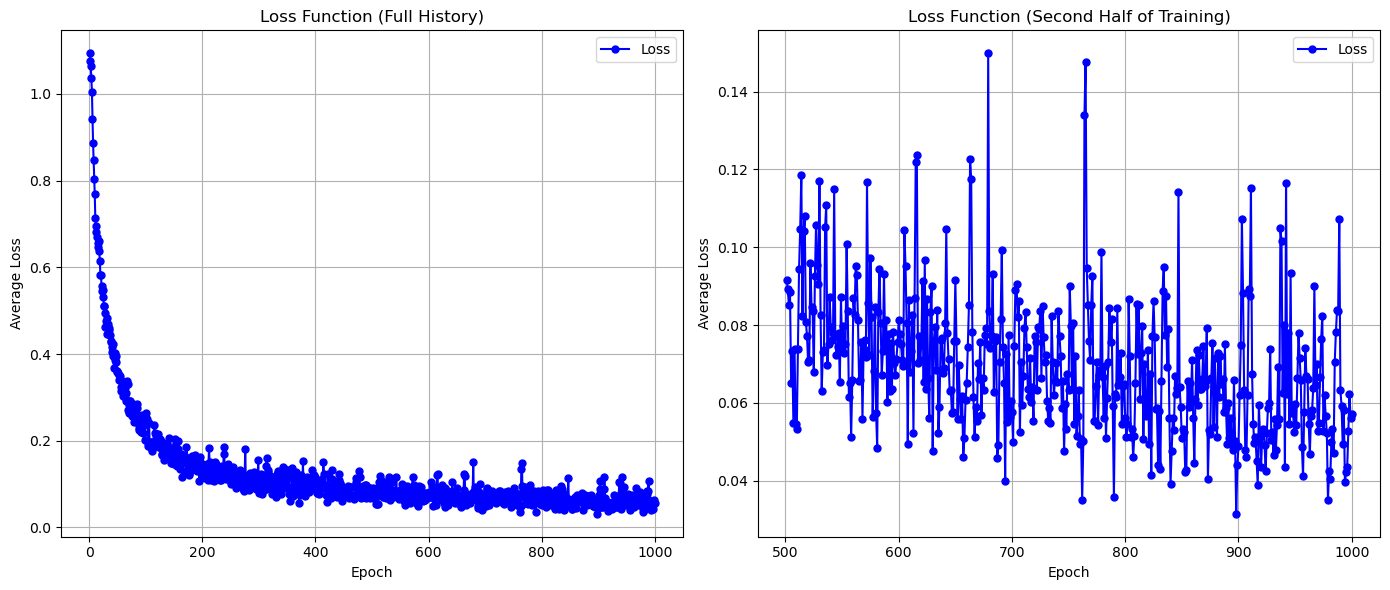

In [50]:
trainer5.plot_training_history()

#### Оценка

In [51]:
trainer5.evaluate(cifar100_005)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9980    1.0000    0.9990       500
  chimpanzee     1.0000    0.9980    0.9990       500
    mushroom     1.0000    1.0000    1.0000       500

    accuracy                         0.9993      1500
   macro avg     0.9993    0.9993    0.9993      1500
weighted avg     0.9993    0.9993    0.9993      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.8300    0.8300    0.8300       100
  chimpanzee     0.8061    0.7900    0.7980       100
    mushroom     0.8137    0.8300    0.8218       100

    accuracy                         0.8167       300
   macro avg     0.8166    0.8167    0.8166       300
weighted avg     0.8166    0.8167    0.8166       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [52]:
trainer5.save_model(cifar100_005)

Model saved as: cifar100_4f92478a-f95a-4400-bc4b-6d79a8539d60.onnx
Model UUID: 4f92478a-f95a-4400-bc4b-6d79a8539d60
